In [ ]:
# @title LOAD DATASET
%%capture
!gdown --folder https://drive.google.com/drive/folders/13FPSFr3IrRghm8BXj4g5nF28X3keLgwW?usp=drive_link
!gdown --folder https://drive.google.com/drive/folders/1F7BpqvWrf8E3nh6oaTKEJc09ibT6Igh_?usp=drive_link

!unzip /content/bachi/clean_skilk_dataset.zip -d d

In [ ]:
# @title IMPORT
import os
from glob import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay

import torchvision
from torchvision import models, transforms
import torchvision.transforms.functional as TF

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from torchsummary import summary

from time import time

from google.colab import files
from collections import Counter





In [ ]:
# @title GLOBAL


lr= 0.0001
batch_size = 32
num_epochs= 10
patience= 10


transform_512 = transforms.Compose([
    transforms.Resize((512, 512)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_256 = transforms.Compose([
    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_crop_512 = transforms.Compose([

    transforms.RandomResizedCrop(512, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_crop_256 = transforms.Compose([

    transforms.RandomResizedCrop(256, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_crop_128 = transforms.Compose([

    transforms.RandomResizedCrop(128, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

eval_transform_512=transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

eval_transform_256=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

eval_transform_128=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

pre_trained_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(0))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# @title UTILS

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

def accuracy(yhat, y):
    preds = torch.max(yhat, 1)[1]
    correct = (preds == y).sum().item()
    total = y.size(0)
    acc = correct / total
    return acc

def load_image_paths(root):
    image_paths = []
    labels = []
    for label in ['0', '1']: #sottocartelle chiamate '0' e '1'
        class_dir = os.path.join(root, label) # percorso per le sottocartelle
        for img_path in glob(os.path.join(class_dir, '*.jpg')): #cerca i file nelle sottocartelle
            image_paths.append(img_path) #lista con i percorsi di tutte le immagini
            labels.append(int(label)) #in parallelo castiamo il nome della sottocartella relativa in int
    return image_paths, labels

def split_dataset(image_paths, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, stratify=labels, test_size=(1 - train_ratio), random_state=42)

    val_size = val_ratio / (val_ratio + test_ratio)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=(1 - val_size), random_state=42)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)



class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label






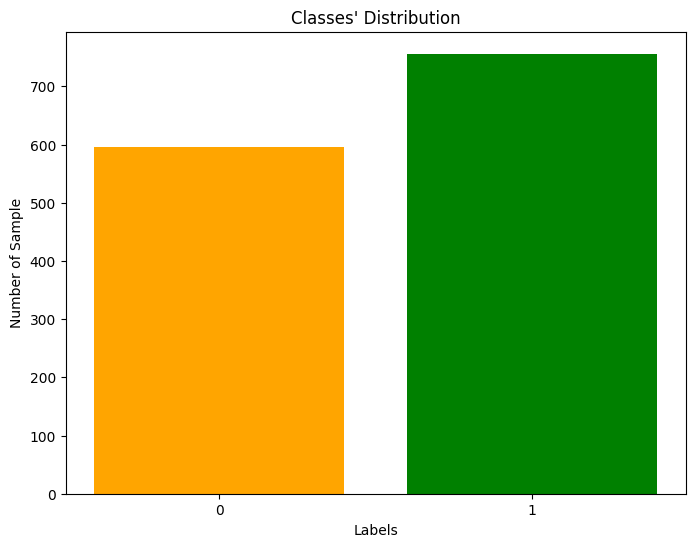

Number of sample in the TRAIN dataset: 945
Number of sample in the VALIDATION dataset: 203
Number of sample in the TEST dataset: 203


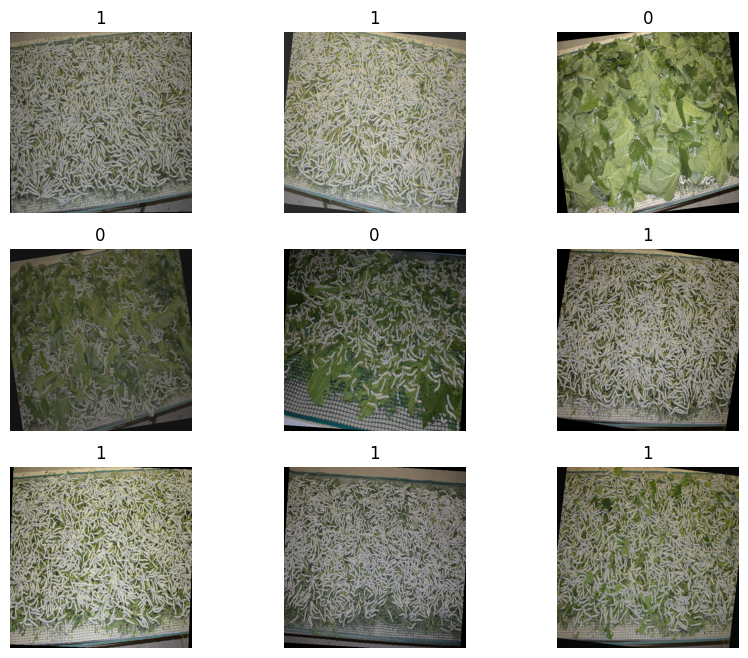

In [ ]:
# @title DATA

img_paths, labels = load_image_paths('/content/d/content/dataset/clean_skilk_dataset')

# Histogramma

label_counts = Counter(labels)
class_names = [str(label) for label in label_counts.keys()]
counts = list(label_counts.values())

# plot hist
plt.figure(figsize=(8, 6))
plt.bar(class_names, counts, color=['orange', 'green'])
plt.xlabel("Labels")
plt.ylabel("Number of Sample")
plt.title("Classes' Distribution")
plt.show()


(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = split_dataset(img_paths, labels)

train_set = ImageDataset(train_paths, train_labels,transform=transform_512)
val_set = ImageDataset(val_paths, val_labels,transform=eval_transform_512)
test_set = ImageDataset(test_paths, test_labels,transform=eval_transform_512)

print(f"Number of sample in the TRAIN dataset: {len(train_set)}")
print(f"Number of sample in the VALIDATION dataset: {len(val_set)}")
print(f"Number of sample in the TEST dataset: {len(test_set)}")

# denormalize for visualizaion
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]

    img = denormalize(img, mean, std)

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0)) #imshow si aspetta shape (h,w,channels)
plt.show()


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
vali_loader = DataLoader(val_set, batch_size = batch_size, shuffle= True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
# @title Models


class BasicBlock(nn.Module): #post-activation
    expansion = 1

    def __init__(self, in_channels, filterts, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, filterts, kernel_size=3, stride=stride, padding=1, bias=False) #bias false prima della bn (true è inutile)
        self.bn1 = nn.BatchNorm2d(filterts)
        self.conv2 = nn.Conv2d(filterts, filterts, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(filterts)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*filterts:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*filterts, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*filterts)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2): #passare la lista col numero di blocchi per layer
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) #ogni layer a parte il primo dimezza la dimensione dell'immagine attraverso lo stride all'interno dei blocchi residuali
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.pool = nn.AdaptiveAvgPool2d(1)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.pool(out) #sistemare in base alle dimensioni in input
        out = torch.flatten(out, start_dim=1) #mantengo solo la dimensione del batch
        out = self.linear(out)
        return out


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)


class CNNdepthwiseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=4):
        super().__init__()
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)
        mid_channels = in_channels * expansion

        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU6(inplace=True)
        )

        self.depthwise = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1,
                      groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU6(inplace=True)
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        identity = x
        out = self.expand(x)
        out = self.depthwise(out)
        out = self.pointwise(out)
        if self.use_residual:
            out += identity
        return out



class MobileVitBlock(nn.Module):
    def __init__(self, in_channels, transformer_dim, patch_size=2, layer=2):
        super(MobileVitBlock, self).__init__()
        self.patch_size = patch_size
        self.transformer_dim = transformer_dim

        # local feature extraction
        self.local_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        )

        # Proiezione flattenata (C * patch_area) -> transformer_dim
        patch_area = patch_size * patch_size
        self.linear_in = nn.Linear(in_channels * patch_area, transformer_dim)
        self.linear_out = nn.Linear(transformer_dim, in_channels * patch_area)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=4,
            dim_feedforward= 2 * transformer_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layer)

        # Fusion conv (dopo il fold)
        self.fusionconv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x.clone()

        # local convolution
        x = self.local_conv(x)  # (B, C, H, W)
        B, C, H, W = x.size() #save size to fold it
        patch_area = self.patch_size * self.patch_size

        # unfold :(B, C*patch_area, num_patches)
        x = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size)


        # reshape → (B, num_patches, C*patch_area)
        x = x.transpose(1, 2)

        # Linear projection to transformer_dim
        x = self.linear_in(x)  # (B, num_patches, transformer_dim)

        # Transformer encoder
        x = self.transformer(x)  # (B, num_patches, transformer_dim)

        # Project back to original patch dim
        x = self.linear_out(x)  # (B, num_patches, C*patch_area)

        # reshape back → (B, C*patch_area, num_patches)
        x = x.transpose(1, 2)

        # fold to (B, C, H, W)
        x = F.fold(x, output_size=(H, W), kernel_size=self.patch_size, stride=self.patch_size)

        # fuse with residual
        x = self.fusionconv(torch.cat([x, residual], dim=1))

        return x

class MobileVit(nn.Module):
    def __init__(self,  in_channels, channels, dims, patch_size=2, expansion=4,attn=True):
        super(MobileVit, self).__init__()
        self.attn=attn
        self.firststride = nn.Sequential(
            nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0]),
            nn.ReLU(inplace=True),
            CNNdepthwiseBlock(channels[0], channels[1], stride=1, expansion=expansion)
        )  # output stride=2

        self.secondstride = nn.Sequential(
            CNNdepthwiseBlock(channels[1], channels[2], stride=2, expansion=expansion),
        )  # output stride=4

        self.thirdstride = nn.Sequential(
            CNNdepthwiseBlock(channels[2], channels[3], stride=2, expansion=expansion),
            MobileVitBlock(channels[3], dims[0], patch_size, layer=2)
        )  # output stride=8

        self.fourthstride = nn.Sequential(
            CNNdepthwiseBlock(channels[3], channels[4], stride=2, expansion=expansion),
            MobileVitBlock(channels[4], dims[1], patch_size, layer=4)
        )  # output stride=16

        self.fifthstride = nn.Sequential(
            CNNdepthwiseBlock(channels[4], channels[5], stride=2, expansion=expansion),
            MobileVitBlock(channels[5], dims[2], patch_size, layer=3),
            nn.Conv2d(channels[5], channels[6], kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(channels[6]),
            nn.ReLU(inplace=True)
        )  # output stride=32

        if attn:
          self.pool = AttentionPooling(channels[6])
        else:
          self.pool = nn.AdaptiveAvgPool2d(1)

        self.clf = nn.Linear(channels[6], channels[7])

    def forward(self, x):
        x = self.firststride(x)
        x = self.secondstride(x)
        x = self.thirdstride(x)
        x = self.fourthstride(x)
        x = self.fifthstride(x)
        x = self.pool(x)        # Output shape: [B, C, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten : [B, C]
        x = self.clf(x)            # Output shape: [B, num_classes]
        return x




class AttentionPooling(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.attn_mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, 1)
        )

    def forward(self, x):
        x = x.flatten(2)
        # x: [B, C, F] → we transpose to [B, F, C]
        x = x.transpose(1, 2)  # [B, F, C]
        attn_logits = self.attn_mlp(x)  # [B, F, 1]
        weights = torch.softmax(attn_logits, dim=1)  # [B, F, 1]
        weighted_sum = (x * weights).sum(dim=1)  # [B, C]
        return weighted_sum


class MiniCNN(nn.Module):
    def __init__(self, num_classes=2, attn=False):
        super().__init__()

        self.attn=attn
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),  # 512 → 256
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.block1 = CNNdepthwiseBlock(32, 64, stride=2)    # 256 → 128
        self.block2 = CNNdepthwiseBlock(64, 128, stride=2)   # 128 → 64
        self.block3 = CNNdepthwiseBlock(128, 128, stride=1)  # residuo
        self.block4 = CNNdepthwiseBlock(128, 256, stride=2)  # 64 → 32

        self.block5 = CNNdepthwiseBlock(256, 256, stride=1)  # residuo
        if attn:
          self.pool = AttentionPooling(256)
        else:
          self.pool = nn.AdaptiveAvgPool2d(1)


        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)      # [B, 256]
        x = self.fc(x)          # [B, num_classes]
        return x


def xxs(attn=False):
    dims = [64, 80, 96]
    channels = [16, 16, 24, 48,  64, 80, 320, 2]
    return MobileVit(3, channels, dims, expansion=2, attn=attn)


def xs(attn=False):
    dims = [96, 120, 144]
    channels = [16, 32, 48, 64, 80,  96, 384, 2]
    return MobileVit(3, channels, dims, attn=attn)


def s(attn=False):
    dims = [144, 192, 240]
    channels = [16, 32, 64, 96,  128, 160, 640, 2]
    return MobileVit(3, channels, dims, attn=attn)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



img = torch.randn(5, 3, 128, 128)

vit = xxs()
out = vit(img)
print(f'xxs:{out.shape}')
print(count_parameters(vit))

vit = xs()
out = vit(img)
print(f'xs:{out.shape}')
print(count_parameters(vit))
vit = s()
out = vit(img)
print(f's:{out.shape}')
print(count_parameters(vit))

model = MiniCNN().to(device)
summary(model, (3, 512, 512))

xxs:torch.Size([5, 2])
1040898
xs:torch.Size([5, 2])
2068858
s:torch.Size([5, 2])
5327074
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]           4,096
       BatchNorm2d-5        [-1, 128, 256, 256]             256
             ReLU6-6        [-1, 128, 256, 256]               0
            Conv2d-7        [-1, 128, 128, 128]           1,152
       BatchNorm2d-8        [-1, 128, 128, 128]             256
             ReLU6-9        [-1, 128, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]           8,192
      BatchNorm2d-11         [-1, 64, 128, 128]             128
CNNdepthwiseBlock-12         [-1, 64, 128, 128]               0
           Co

In [ ]:
# @title Training and evaluation function
def train(data_loader, model, optimizer, criterion, metric_function, device):
    total_loss = 0
    total_accuracy = 0
    model.train()

    for xb,yb in data_loader:
        xb=xb.to(device)
        yb=yb.to(device)
        optimizer.zero_grad()

        outputs= model(xb)
        accuracy= metric_function(outputs.detach(), yb)
        loss = criterion(outputs, yb)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy


    return total_loss / len(data_loader), total_accuracy/len(data_loader)

def evaluate(vali_loader, model, criterion, metric_func, device):
    total_loss = 0
    total_accuracy = 0
    model.eval()

    t0=time()

    with torch.no_grad():
        for xb, yb in vali_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            outputs = model(xb)
            accuracy = metric_func(outputs, yb)
            loss = criterion(outputs, yb)

            total_loss += loss.item()
            total_accuracy += accuracy
    t1=time()
    tempo=t1-t0
    return total_loss / len(vali_loader), total_accuracy / len(vali_loader) ,tempo


def test(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    total_time = 0.0
    total_images = 0

    with torch.no_grad():
        for img, labels in dataloader:
            img = img.to(device)
            labels = labels.to(device)

            start_time = time()
            outputs = model(img)
            end_time = time()

            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_time += (end_time - start_time)
            total_images += img.size(0)

    avg_inference_time = total_time / total_images if total_images > 0 else 0

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy           : {acc:.4f}")
    print(f"Precision          : {prec:.4f}")
    print(f"Recall             : {rec:.4f}")
    print(f"F1 Score           : {f1:.4f}")
    print(f"Inference time/img : {avg_inference_time:.6f} seconds")
    print(f"Confusion Matrix:\n{cm}")

    return acc, prec, rec, f1, cm, avg_inference_time


def train_model(epochs,train_loader,vali_loader,model,optimizer , criterion , metric_function, patience, device , save_path= "best_model.pt"):
    history = {   "train_loss": [], "train_acc": [],
                    "val_loss": [], "val_acc": [] }

    best_val_loss = np.inf
    patience_counter = 0

    for epoch in range(epochs):
        train_loss, train_acc = train(train_loader, model, optimizer, criterion, metric_function, device)
        val_loss, val_acc,eval_time = evaluate(vali_loader, model, criterion, metric_function, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Val loss:{val_loss:.4f} Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}, Time: {eval_time:.2f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            patience_counter = 0
            print(f'save best model at epoch: {epoch}')

        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    #plot_history(history)

def plot_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.tight_layout()
    plt.show()


[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.4290, Val loss:0.6408 Train acc: 0.8118, Val acc: 0.5016, Time: 10.37
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3114, Val loss:0.1827 Train acc: 0.8802, Val acc: 0.9375, Time: 10.43
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2741, Val loss:0.1760 Train acc: 0.8865, Val acc: 0.9509, Time: 10.33
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2993, Val loss:0.1911 Train acc: 0.8786, Val acc: 0.9379, Time: 10.25
Epoch 5/10 - Train loss: 0.2669, Val loss:0.1586 Train acc: 0.9055, Val acc: 0.9554, Time: 10.41
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2604, Val loss:0.1460 Train acc: 0.8971, Val acc: 0.9598, Time: 10.30
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2419, Val loss:0.1784 Train acc: 0.8963, Val acc: 0.9156, Time: 10.36
Epoch 8/10 - Train loss: 0.2519, Val loss:0.1763 Train acc: 0.9037, Val acc: 0.9107, Time: 10.22
Epoch 9/10

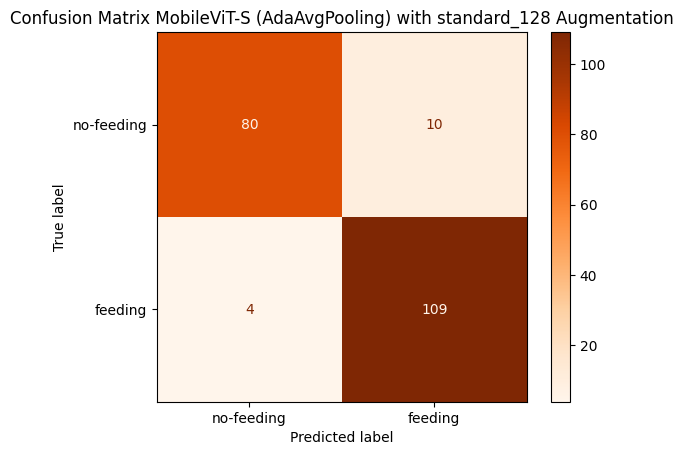

[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.4366, Val loss:2.1752 Train acc: 0.8015, Val acc: 0.4399, Time: 10.86
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3016, Val loss:0.1808 Train acc: 0.8754, Val acc: 0.9598, Time: 10.71
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2730, Val loss:0.1659 Train acc: 0.8930, Val acc: 0.9241, Time: 10.51
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2428, Val loss:0.2100 Train acc: 0.9062, Val acc: 0.9115, Time: 10.53
Epoch 5/10 - Train loss: 0.2236, Val loss:0.1480 Train acc: 0.9156, Val acc: 0.9245, Time: 10.64
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2362, Val loss:0.1302 Train acc: 0.9015, Val acc: 0.9643, Time: 10.60
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2212, Val loss:0.1383 Train acc: 0.9219, Val acc: 0.9692, Time: 10.56
Epoch 8/10 - Train loss: 0.2378, Val loss:0.1398 Train acc: 0.9116, Val acc: 0.9513, Time: 10.60
Epoch 9/10

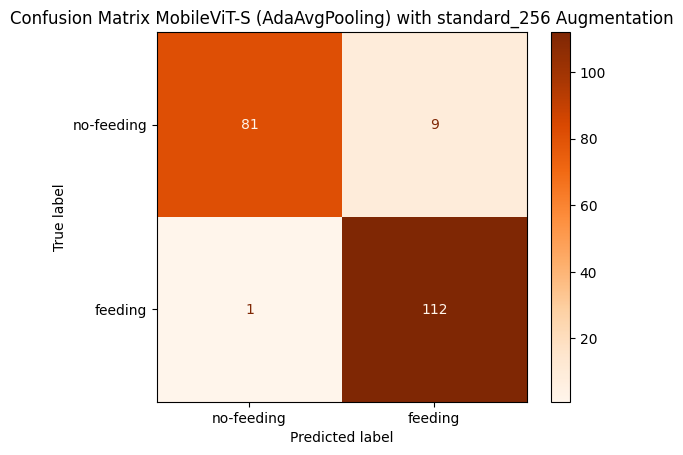

[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.3663, Val loss:0.4331 Train acc: 0.8271, Val acc: 0.9420, Time: 12.55
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2827, Val loss:0.1659 Train acc: 0.8837, Val acc: 0.9290, Time: 12.79
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2487, Val loss:0.1436 Train acc: 0.9032, Val acc: 0.9334, Time: 12.45
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2277, Val loss:0.1642 Train acc: 0.9116, Val acc: 0.9424, Time: 12.78
Epoch 5/10 - Train loss: 0.2490, Val loss:0.1483 Train acc: 0.9035, Val acc: 0.9558, Time: 12.60
Epoch 6/10 - Train loss: 0.2411, Val loss:0.1304 Train acc: 0.9043, Val acc: 0.9643, Time: 12.65
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2290, Val loss:0.1263 Train acc: 0.9126, Val acc: 0.9688, Time: 12.62
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2151, Val loss:0.1101 Train acc: 0.9127, Val acc: 0.9643, Time: 12.74
save best 

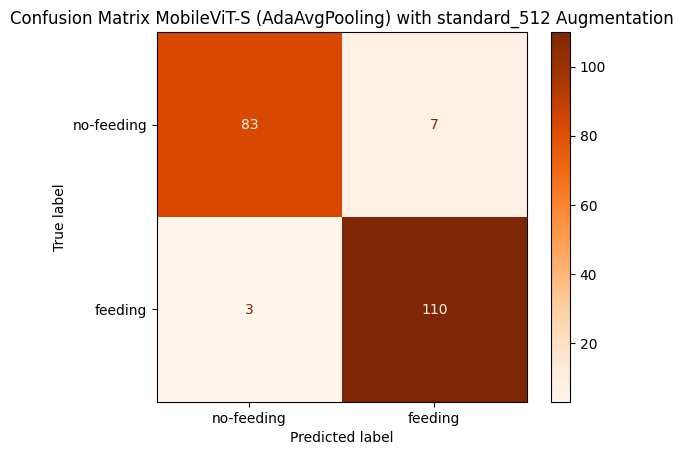

[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.4034, Val loss:0.8148 Train acc: 0.8212, Val acc: 0.4399, Time: 10.11
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3201, Val loss:0.1821 Train acc: 0.8784, Val acc: 0.9156, Time: 9.89
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2874, Val loss:0.1558 Train acc: 0.8855, Val acc: 0.9554, Time: 9.90
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2619, Val loss:0.1308 Train acc: 0.8887, Val acc: 0.9598, Time: 9.85
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2633, Val loss:0.1582 Train acc: 0.8881, Val acc: 0.9464, Time: 9.80
Epoch 6/10 - Train loss: 0.2797, Val loss:0.1734 Train acc: 0.8839, Val acc: 0.9424, Time: 10.15
Epoch 7/10 - Train loss: 0.2636, Val loss:0.1218 Train acc: 0.9045, Val acc: 0.9464, Time: 10.09
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2166, Val loss:0.1150 Train acc: 0.9126, Val acc: 0.9643, Time: 10.10
save best model at

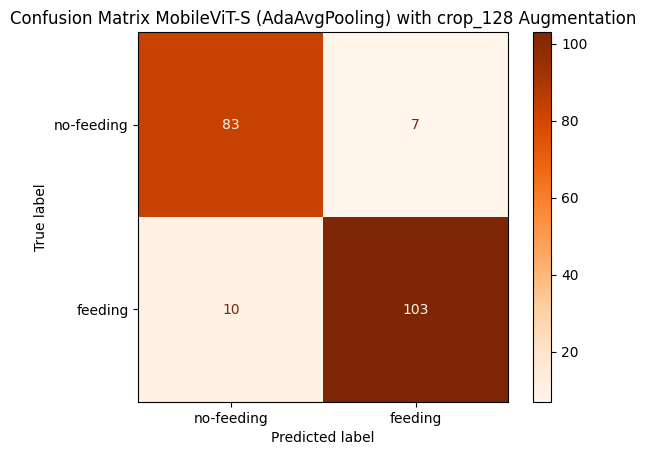

[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.3253, Val loss:2.2688 Train acc: 0.8670, Val acc: 0.4314, Time: 10.55
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2831, Val loss:0.1877 Train acc: 0.8907, Val acc: 0.9294, Time: 10.45
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2425, Val loss:0.1548 Train acc: 0.9135, Val acc: 0.9330, Time: 10.75
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2367, Val loss:0.1994 Train acc: 0.9074, Val acc: 0.9071, Time: 10.63
Epoch 5/10 - Train loss: 0.2467, Val loss:0.1522 Train acc: 0.9107, Val acc: 0.9286, Time: 10.84
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2318, Val loss:0.1573 Train acc: 0.9086, Val acc: 0.9424, Time: 10.72
Epoch 7/10 - Train loss: 0.1996, Val loss:0.1570 Train acc: 0.9126, Val acc: 0.9290, Time: 10.58
Epoch 8/10 - Train loss: 0.2280, Val loss:0.1601 Train acc: 0.9117, Val acc: 0.9160, Time: 10.62
Epoch 9/10 - Train loss: 0.2194, Val loss:

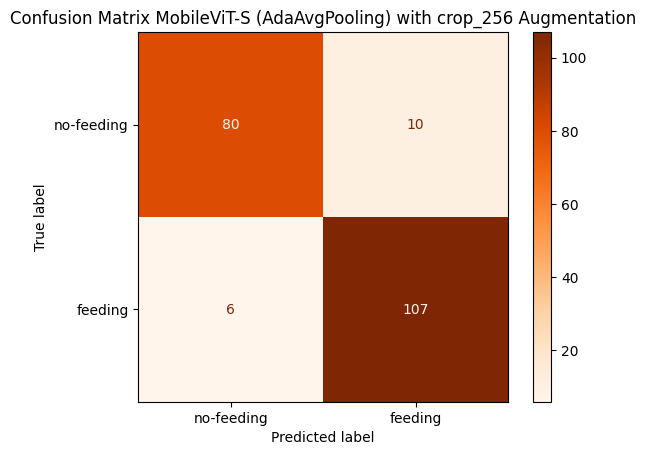

[RESULT] Model: MobileViT-S (AdaAvgPooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3593, Val loss:1.4219 Train acc: 0.8470, Val acc: 0.4399, Time: 12.83
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2509, Val loss:0.1720 Train acc: 0.9000, Val acc: 0.9602, Time: 12.73
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2802, Val loss:0.2968 Train acc: 0.8948, Val acc: 0.9205, Time: 12.74
Epoch 4/10 - Train loss: 0.2539, Val loss:0.1764 Train acc: 0.9032, Val acc: 0.9598, Time: 13.23
Epoch 5/10 - Train loss: 0.2190, Val loss:0.1461 Train acc: 0.9148, Val acc: 0.9464, Time: 12.96
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2301, Val loss:0.1743 Train acc: 0.9127, Val acc: 0.9294, Time: 12.65
Epoch 7/10 - Train loss: 0.2123, Val loss:0.1726 Train acc: 0.9180, Val acc: 0.9513, Time: 13.53
Epoch 8/10 - Train loss: 0.2073, Val loss:0.1367 Train acc: 0.9302, Val acc: 0.9554, Time: 12.91
save best model at epoch: 7
Epoch 9/10 - Train loss: 0.2031, Val loss:

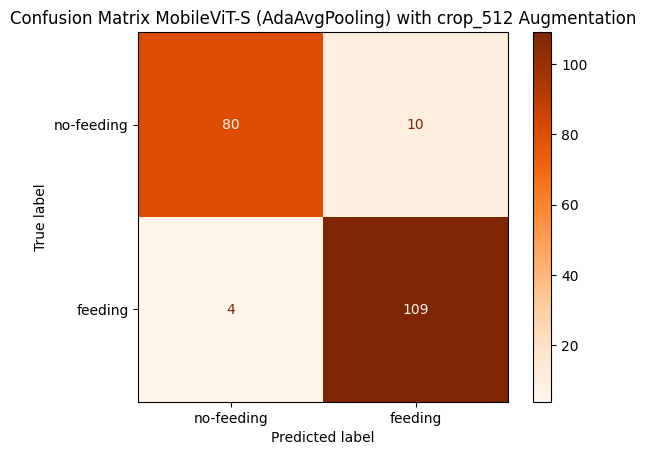

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.4593, Val loss:1.0811 Train acc: 0.7689, Val acc: 0.4399, Time: 10.61
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3164, Val loss:0.1771 Train acc: 0.8703, Val acc: 0.9468, Time: 10.35
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2791, Val loss:0.1594 Train acc: 0.8953, Val acc: 0.9598, Time: 10.26
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2678, Val loss:0.2183 Train acc: 0.8868, Val acc: 0.9067, Time: 10.42
Epoch 5/10 - Train loss: 0.2540, Val loss:0.1870 Train acc: 0.8970, Val acc: 0.9468, Time: 9.93
Epoch 6/10 - Train loss: 0.2497, Val loss:0.1883 Train acc: 0.8924, Val acc: 0.9111, Time: 10.35
Epoch 7/10 - Train loss: 0.2705, Val loss:0.1474 Train acc: 0.8793, Val acc: 0.9468, Time: 10.26
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2323, Val loss:0.1568 Train acc: 0.9064, Val acc: 0.9420, Time: 10.29
Epoch 9/10 - Train loss: 0.2487, Val los

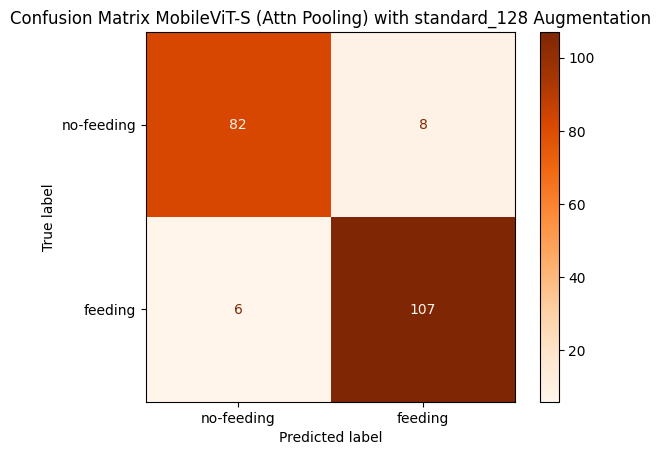

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.4219, Val loss:0.8851 Train acc: 0.8065, Val acc: 0.5601, Time: 10.66
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2577, Val loss:0.2058 Train acc: 0.8980, Val acc: 0.9245, Time: 10.46
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2688, Val loss:0.1790 Train acc: 0.8980, Val acc: 0.9249, Time: 10.57
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2029, Val loss:0.1473 Train acc: 0.9189, Val acc: 0.9379, Time: 10.64
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2332, Val loss:0.2018 Train acc: 0.9073, Val acc: 0.9107, Time: 10.65
Epoch 6/10 - Train loss: 0.2316, Val loss:0.1387 Train acc: 0.9148, Val acc: 0.9509, Time: 10.49
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2087, Val loss:0.1818 Train acc: 0.9095, Val acc: 0.9200, Time: 10.55
Epoch 8/10 - Train loss: 0.2138, Val loss:0.1592 Train acc: 0.9180, Val acc: 0.9196, Time: 10.54
Epoch 9/10 

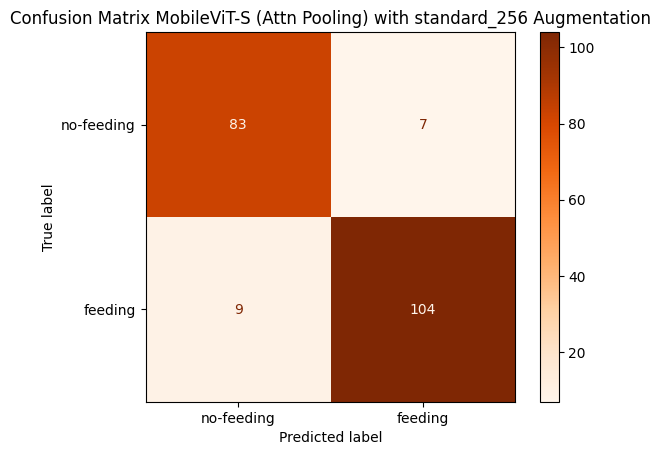

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.3570, Val loss:3.1083 Train acc: 0.8327, Val acc: 0.4314, Time: 12.50
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2719, Val loss:0.2074 Train acc: 0.9021, Val acc: 0.9334, Time: 12.61
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2506, Val loss:0.2465 Train acc: 0.9043, Val acc: 0.8892, Time: 12.49
Epoch 4/10 - Train loss: 0.2319, Val loss:0.1801 Train acc: 0.9146, Val acc: 0.9290, Time: 12.57
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2171, Val loss:0.1374 Train acc: 0.9075, Val acc: 0.9554, Time: 12.53
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2284, Val loss:0.1262 Train acc: 0.9230, Val acc: 0.9643, Time: 12.43
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2343, Val loss:0.1955 Train acc: 0.9042, Val acc: 0.9160, Time: 12.61
Epoch 8/10 - Train loss: 0.2045, Val loss:0.2296 Train acc: 0.9202, Val acc: 0.8985, Time: 12.71
Epoch 9/10 

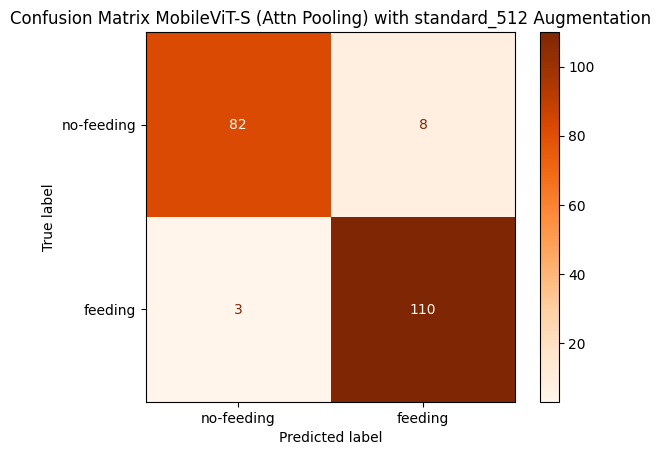

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.4442, Val loss:0.4180 Train acc: 0.7648, Val acc: 0.7999, Time: 9.93
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3052, Val loss:0.1978 Train acc: 0.8765, Val acc: 0.9330, Time: 10.05
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2647, Val loss:0.1291 Train acc: 0.8920, Val acc: 0.9598, Time: 10.03
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2558, Val loss:0.1330 Train acc: 0.8960, Val acc: 0.9509, Time: 10.13
Epoch 5/10 - Train loss: 0.2654, Val loss:0.1544 Train acc: 0.8930, Val acc: 0.9643, Time: 10.17
Epoch 6/10 - Train loss: 0.2498, Val loss:0.1321 Train acc: 0.9012, Val acc: 0.9558, Time: 10.01
Epoch 7/10 - Train loss: 0.2369, Val loss:0.1645 Train acc: 0.9148, Val acc: 0.9379, Time: 10.14
Epoch 8/10 - Train loss: 0.2450, Val loss:0.1573 Train acc: 0.9053, Val acc: 0.9558, Time: 10.13
Epoch 9/10 - Train loss: 0.2404, Val loss:0.1256 Train acc: 0.8979, Val 

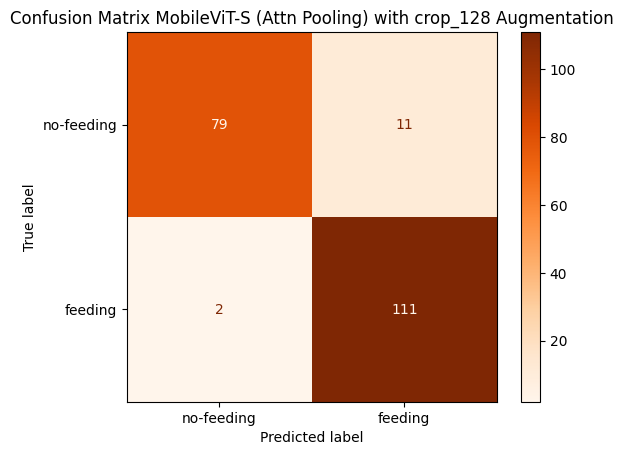

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.3645, Val loss:1.1878 Train acc: 0.8438, Val acc: 0.4570, Time: 10.84
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2567, Val loss:0.1565 Train acc: 0.8919, Val acc: 0.9513, Time: 10.60
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2486, Val loss:0.1477 Train acc: 0.8952, Val acc: 0.9558, Time: 10.84
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2446, Val loss:0.1228 Train acc: 0.9116, Val acc: 0.9643, Time: 10.85
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2335, Val loss:0.1672 Train acc: 0.9156, Val acc: 0.9334, Time: 10.72
Epoch 6/10 - Train loss: 0.2527, Val loss:0.1958 Train acc: 0.8919, Val acc: 0.9509, Time: 10.67
Epoch 7/10 - Train loss: 0.2129, Val loss:0.1172 Train acc: 0.9139, Val acc: 0.9688, Time: 10.67
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2142, Val loss:0.1210 Train acc: 0.9210, Val acc: 0.9598, Time: 10.77
Epoch 9/10 - Tr

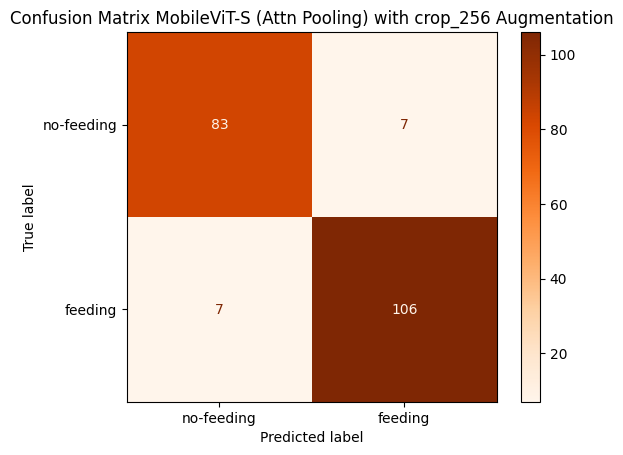

[RESULT] Model: MobileViT-S (Attn Pooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3435, Val loss:3.3680 Train acc: 0.8506, Val acc: 0.4485, Time: 12.96
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2488, Val loss:0.2874 Train acc: 0.9126, Val acc: 0.8628, Time: 12.60
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2436, Val loss:0.1881 Train acc: 0.9108, Val acc: 0.9152, Time: 12.90
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2458, Val loss:0.1395 Train acc: 0.8970, Val acc: 0.9509, Time: 12.74
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2266, Val loss:0.1880 Train acc: 0.9064, Val acc: 0.9428, Time: 12.70
Epoch 6/10 - Train loss: 0.2141, Val loss:0.1379 Train acc: 0.9210, Val acc: 0.9464, Time: 12.81
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.1993, Val loss:0.1747 Train acc: 0.9190, Val acc: 0.9334, Time: 12.94
Epoch 8/10 - Train loss: 0.1842, Val loss:0.1917 Train acc: 0.9265, Val acc: 0.9290, Time: 12.90
Epoch 9/10 - Tr

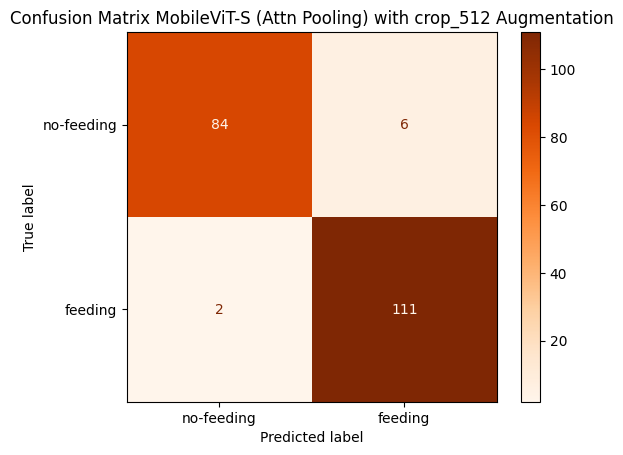

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.5226, Val loss:0.4833 Train acc: 0.7433, Val acc: 0.8275, Time: 10.15
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3283, Val loss:0.1811 Train acc: 0.8631, Val acc: 0.9643, Time: 9.99
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2740, Val loss:0.1621 Train acc: 0.8869, Val acc: 0.9424, Time: 9.96
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2420, Val loss:0.1825 Train acc: 0.9043, Val acc: 0.9334, Time: 9.96
Epoch 5/10 - Train loss: 0.2711, Val loss:0.1596 Train acc: 0.8949, Val acc: 0.9424, Time: 9.98
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2512, Val loss:0.1554 Train acc: 0.8950, Val acc: 0.9554, Time: 10.08
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2592, Val loss:0.1709 Train acc: 0.8867, Val acc: 0.9420, Time: 9.97
Epoch 8/10 - Train loss: 0.2626, Val loss:0.1893 Train acc: 0.8858, Val acc: 0.9334, Time: 10.08
Epoch 9/10 - T

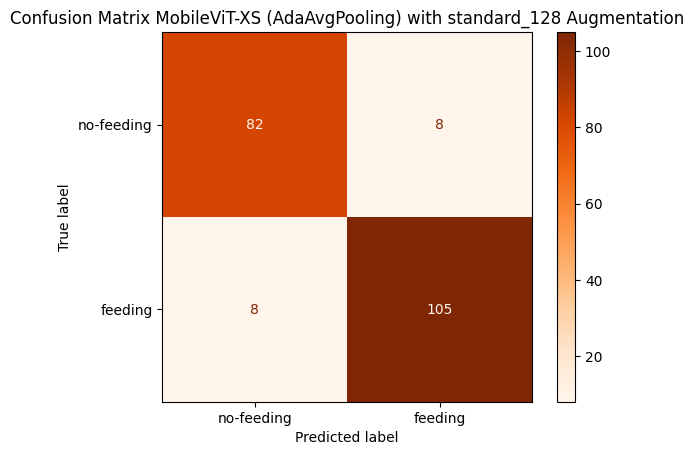

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.4145, Val loss:1.7126 Train acc: 0.8096, Val acc: 0.4570, Time: 10.59
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2513, Val loss:0.2902 Train acc: 0.8991, Val acc: 0.8665, Time: 10.55
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2280, Val loss:0.1344 Train acc: 0.9148, Val acc: 0.9554, Time: 10.50
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2236, Val loss:0.1979 Train acc: 0.9180, Val acc: 0.9200, Time: 10.58
Epoch 5/10 - Train loss: 0.2221, Val loss:0.1458 Train acc: 0.9094, Val acc: 0.9643, Time: 10.61
Epoch 6/10 - Train loss: 0.2169, Val loss:0.1676 Train acc: 0.9146, Val acc: 0.9468, Time: 10.62
Epoch 7/10 - Train loss: 0.2097, Val loss:0.2199 Train acc: 0.9109, Val acc: 0.9152, Time: 10.57
Epoch 8/10 - Train loss: 0.2308, Val loss:0.1550 Train acc: 0.9073, Val acc: 0.9424, Time: 10.71
Epoch 9/10 - Train loss: 0.2104, Val loss:0.1501 Train acc: 0.915

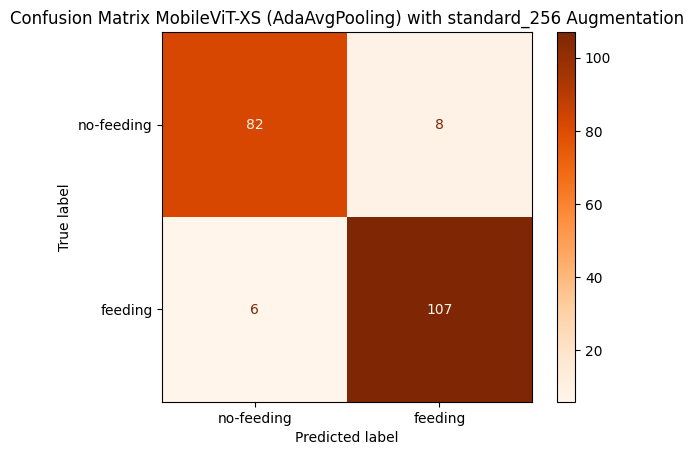

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.3895, Val loss:2.2301 Train acc: 0.8397, Val acc: 0.4399, Time: 12.45
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2685, Val loss:0.2537 Train acc: 0.8979, Val acc: 0.8847, Time: 12.50
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2694, Val loss:0.1733 Train acc: 0.8928, Val acc: 0.9290, Time: 12.44
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2446, Val loss:0.1895 Train acc: 0.9023, Val acc: 0.9330, Time: 12.31
Epoch 5/10 - Train loss: 0.2460, Val loss:0.1863 Train acc: 0.9023, Val acc: 0.9290, Time: 12.01
Epoch 6/10 - Train loss: 0.2244, Val loss:0.1344 Train acc: 0.9126, Val acc: 0.9643, Time: 12.26
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2449, Val loss:0.1482 Train acc: 0.9055, Val acc: 0.9379, Time: 11.98
Epoch 8/10 - Train loss: 0.2459, Val loss:0.1387 Train acc: 0.8991, Val acc: 0.9643, Time: 11.96
Epoch 9/10 - Train loss: 0.2245, Val 

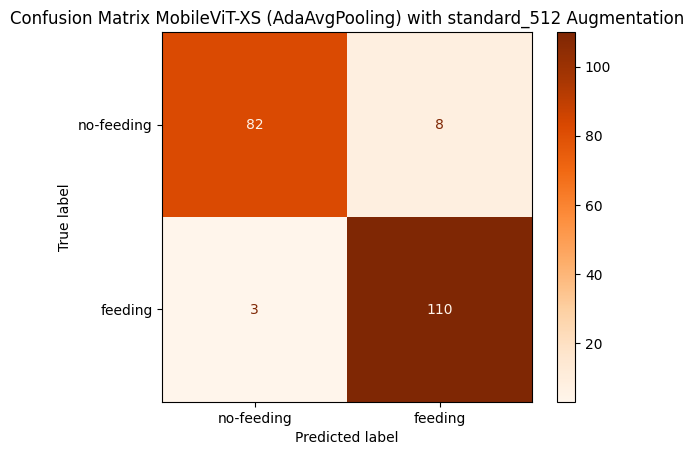

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.4901, Val loss:1.4950 Train acc: 0.7294, Val acc: 0.4399, Time: 9.84
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3105, Val loss:0.1641 Train acc: 0.8773, Val acc: 0.9554, Time: 9.78
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2552, Val loss:0.1313 Train acc: 0.9013, Val acc: 0.9643, Time: 9.77
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2540, Val loss:0.1523 Train acc: 0.8900, Val acc: 0.9420, Time: 9.68
Epoch 5/10 - Train loss: 0.2373, Val loss:0.1641 Train acc: 0.9010, Val acc: 0.9334, Time: 9.81
Epoch 6/10 - Train loss: 0.2498, Val loss:0.1770 Train acc: 0.8971, Val acc: 0.9330, Time: 9.76
Epoch 7/10 - Train loss: 0.2315, Val loss:0.1272 Train acc: 0.9066, Val acc: 0.9424, Time: 9.76
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2372, Val loss:0.1517 Train acc: 0.9013, Val acc: 0.9509, Time: 10.25
Epoch 9/10 - Train loss: 0.2260, Val loss:0.1373

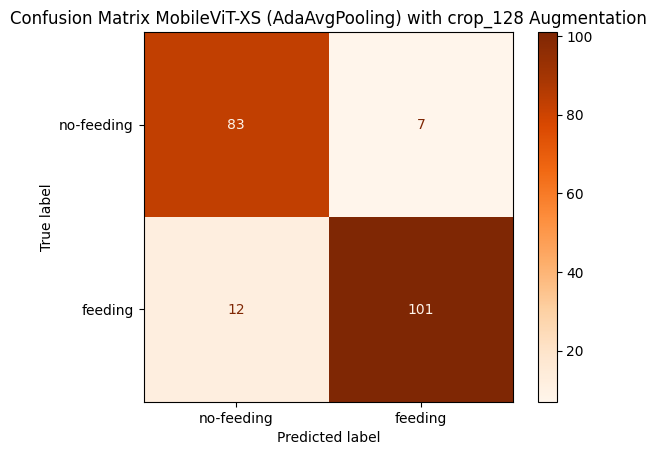

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.4203, Val loss:0.7554 Train acc: 0.8031, Val acc: 0.4444, Time: 10.38
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2927, Val loss:0.1391 Train acc: 0.8812, Val acc: 0.9509, Time: 10.31
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2549, Val loss:0.1733 Train acc: 0.8992, Val acc: 0.9424, Time: 10.56
Epoch 4/10 - Train loss: 0.2483, Val loss:0.1761 Train acc: 0.9042, Val acc: 0.9253, Time: 10.43
Epoch 5/10 - Train loss: 0.2344, Val loss:0.1317 Train acc: 0.9053, Val acc: 0.9602, Time: 10.46
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2562, Val loss:0.1615 Train acc: 0.8942, Val acc: 0.9643, Time: 10.45
Epoch 7/10 - Train loss: 0.2249, Val loss:0.1326 Train acc: 0.9127, Val acc: 0.9464, Time: 10.39
Epoch 8/10 - Train loss: 0.2202, Val loss:0.1489 Train acc: 0.9108, Val acc: 0.9554, Time: 10.33
Epoch 9/10 - Train loss: 0.2064, Val loss:0.1259 Train acc: 0.9302, V

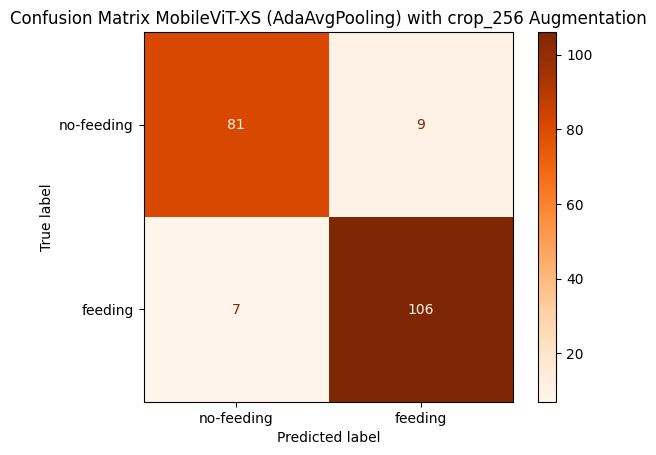

[RESULT] Model: MobileViT-XS (AdaAvgPooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3871, Val loss:2.2058 Train acc: 0.8213, Val acc: 0.4485, Time: 12.13
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2766, Val loss:0.1856 Train acc: 0.8906, Val acc: 0.9334, Time: 12.07
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2457, Val loss:0.1628 Train acc: 0.9075, Val acc: 0.9468, Time: 12.13
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2255, Val loss:0.1557 Train acc: 0.9105, Val acc: 0.9468, Time: 12.04
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2267, Val loss:0.1640 Train acc: 0.9105, Val acc: 0.9602, Time: 12.14
Epoch 6/10 - Train loss: 0.2144, Val loss:0.1705 Train acc: 0.9161, Val acc: 0.9338, Time: 12.02
Epoch 7/10 - Train loss: 0.2222, Val loss:0.1802 Train acc: 0.9105, Val acc: 0.9509, Time: 12.04
Epoch 8/10 - Train loss: 0.2115, Val loss:0.1128 Train acc: 0.9115, Val acc: 0.9732, Time: 12.17
save best model at epoch: 7
Epoch 9/10 - 

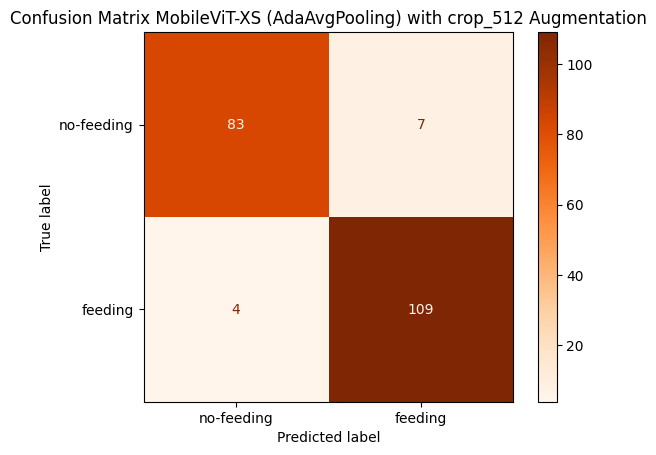

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.4984, Val loss:1.0580 Train acc: 0.7431, Val acc: 0.5686, Time: 9.81
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2856, Val loss:0.1491 Train acc: 0.8931, Val acc: 0.9602, Time: 9.87
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2824, Val loss:0.1493 Train acc: 0.8979, Val acc: 0.9554, Time: 10.12
Epoch 4/10 - Train loss: 0.2932, Val loss:0.1545 Train acc: 0.8803, Val acc: 0.9468, Time: 9.95
Epoch 5/10 - Train loss: 0.2641, Val loss:0.1347 Train acc: 0.8909, Val acc: 0.9643, Time: 9.93
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2510, Val loss:0.1863 Train acc: 0.8961, Val acc: 0.9245, Time: 9.84
Epoch 7/10 - Train loss: 0.2435, Val loss:0.1548 Train acc: 0.8992, Val acc: 0.9598, Time: 9.86
Epoch 8/10 - Train loss: 0.2338, Val loss:0.1281 Train acc: 0.9026, Val acc: 0.9598, Time: 9.86
save best model at epoch: 7
Epoch 9/10 - Train loss: 0.2365, Val loss:0.1

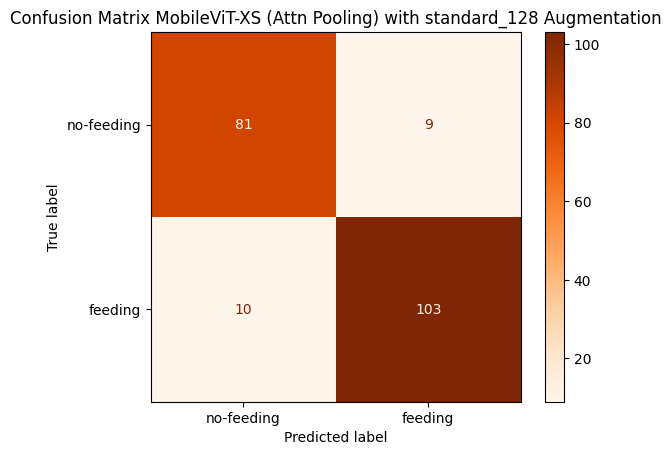

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.4062, Val loss:1.0702 Train acc: 0.8200, Val acc: 0.5284, Time: 10.27
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2980, Val loss:0.2031 Train acc: 0.8772, Val acc: 0.9379, Time: 10.27
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2499, Val loss:0.2277 Train acc: 0.8970, Val acc: 0.8933, Time: 10.25
Epoch 4/10 - Train loss: 0.2612, Val loss:0.2366 Train acc: 0.8990, Val acc: 0.9152, Time: 10.29
Epoch 5/10 - Train loss: 0.2435, Val loss:0.1896 Train acc: 0.9053, Val acc: 0.9160, Time: 10.55
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2029, Val loss:0.1342 Train acc: 0.9148, Val acc: 0.9598, Time: 10.29
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2065, Val loss:0.1251 Train acc: 0.9202, Val acc: 0.9643, Time: 10.20
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2097, Val loss:0.1341 Train acc: 0.9251, Val acc: 0.9509, Time: 10.35
Epoch 9/10

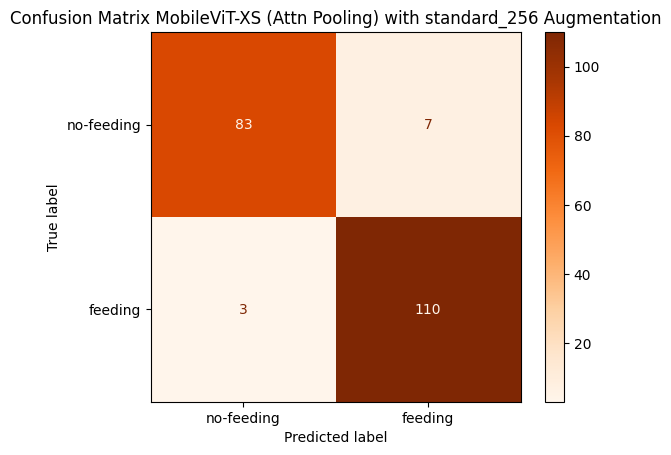

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.3358, Val loss:2.4040 Train acc: 0.8680, Val acc: 0.4058, Time: 11.86
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2851, Val loss:0.2135 Train acc: 0.8958, Val acc: 0.8977, Time: 12.23
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2266, Val loss:0.1676 Train acc: 0.9168, Val acc: 0.9558, Time: 12.01
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2452, Val loss:0.1797 Train acc: 0.8982, Val acc: 0.9424, Time: 11.94
Epoch 5/10 - Train loss: 0.2377, Val loss:0.1874 Train acc: 0.9095, Val acc: 0.9196, Time: 11.85
Epoch 6/10 - Train loss: 0.2229, Val loss:0.1300 Train acc: 0.9125, Val acc: 0.9643, Time: 11.91
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2347, Val loss:0.2213 Train acc: 0.9107, Val acc: 0.9111, Time: 12.01
Epoch 8/10 - Train loss: 0.2134, Val loss:0.1383 Train acc: 0.9116, Val acc: 0.9692, Time: 12.04
Epoch 9/10 - Train loss: 0.2096, Val l

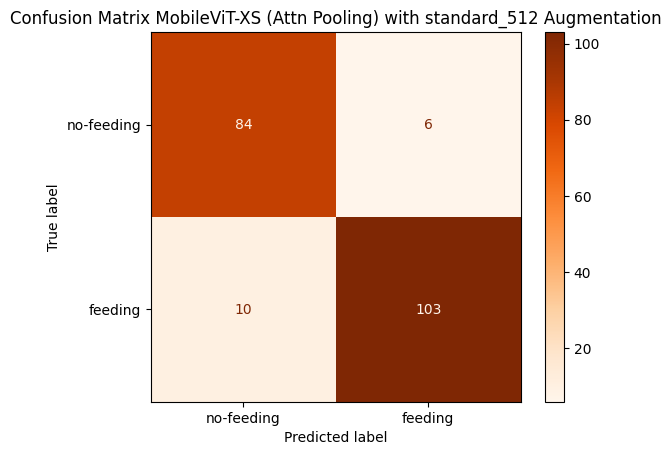

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.5512, Val loss:1.0672 Train acc: 0.7267, Val acc: 0.4399, Time: 9.69
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3332, Val loss:0.1978 Train acc: 0.8588, Val acc: 0.9290, Time: 9.71
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2682, Val loss:0.1835 Train acc: 0.8900, Val acc: 0.9245, Time: 9.86
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.3075, Val loss:0.1878 Train acc: 0.8724, Val acc: 0.9464, Time: 9.80
Epoch 5/10 - Train loss: 0.2749, Val loss:0.1614 Train acc: 0.8909, Val acc: 0.9334, Time: 9.74
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.3031, Val loss:0.1843 Train acc: 0.8835, Val acc: 0.9379, Time: 9.74
Epoch 7/10 - Train loss: 0.2647, Val loss:0.1739 Train acc: 0.8867, Val acc: 0.9464, Time: 9.70
Epoch 8/10 - Train loss: 0.2423, Val loss:0.1730 Train acc: 0.9032, Val acc: 0.9424, Time: 9.71
Epoch 9/10 - Train loss: 0.2513, Val loss:0.1743 T

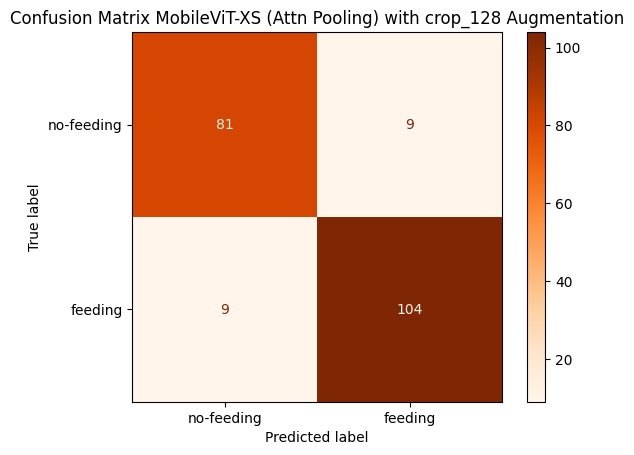

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.4591, Val loss:0.8728 Train acc: 0.7923, Val acc: 0.4700, Time: 10.40
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3373, Val loss:0.1512 Train acc: 0.8621, Val acc: 0.9509, Time: 10.82
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2768, Val loss:0.1650 Train acc: 0.8889, Val acc: 0.9598, Time: 11.14
Epoch 4/10 - Train loss: 0.2533, Val loss:0.1707 Train acc: 0.8971, Val acc: 0.9598, Time: 10.68
Epoch 5/10 - Train loss: 0.2242, Val loss:0.3140 Train acc: 0.9127, Val acc: 0.8718, Time: 10.76
Epoch 6/10 - Train loss: 0.2313, Val loss:0.1488 Train acc: 0.9075, Val acc: 0.9468, Time: 11.05
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2340, Val loss:0.1621 Train acc: 0.9032, Val acc: 0.9554, Time: 10.99
Epoch 8/10 - Train loss: 0.2127, Val loss:0.1341 Train acc: 0.9119, Val acc: 0.9509, Time: 11.06
save best model at epoch: 7
Epoch 9/10 - Train loss: 0.2039, Val loss:

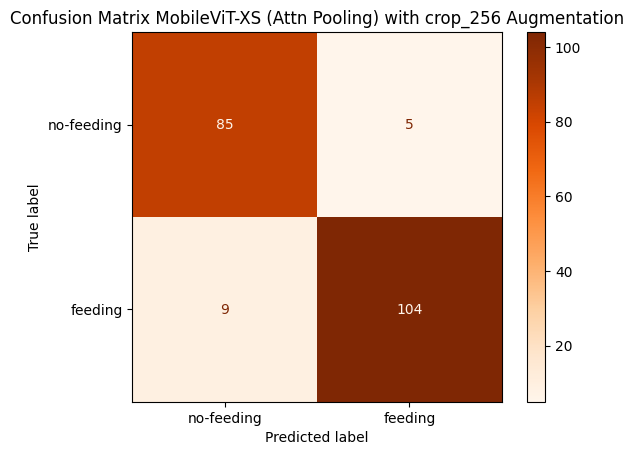

[RESULT] Model: MobileViT-XS (Attn Pooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3918, Val loss:1.5808 Train acc: 0.8400, Val acc: 0.4229, Time: 12.71
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2620, Val loss:0.3141 Train acc: 0.8974, Val acc: 0.8543, Time: 12.92
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2676, Val loss:0.1565 Train acc: 0.9000, Val acc: 0.9424, Time: 12.70
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2332, Val loss:0.1943 Train acc: 0.9053, Val acc: 0.9111, Time: 12.56
Epoch 5/10 - Train loss: 0.2412, Val loss:0.1399 Train acc: 0.9085, Val acc: 0.9554, Time: 12.89
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2242, Val loss:0.1284 Train acc: 0.9104, Val acc: 0.9554, Time: 13.00
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2350, Val loss:0.1199 Train acc: 0.9220, Val acc: 0.9643, Time: 12.85
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2102, Val loss:0.1090 Train acc: 0.9170, Val acc: 0.9643

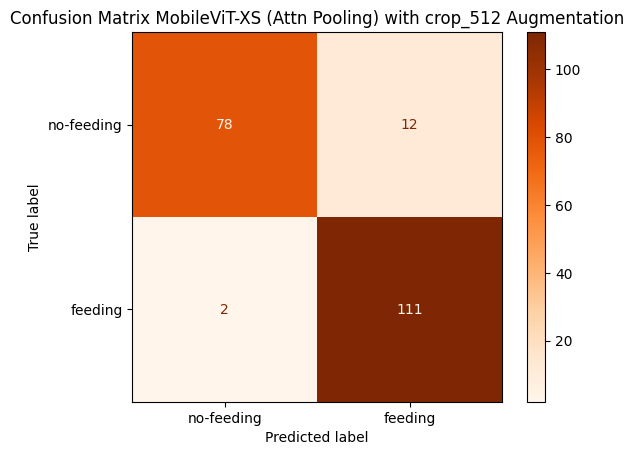

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.6021, Val loss:0.7010 Train acc: 0.6765, Val acc: 0.4485, Time: 10.27
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.4090, Val loss:0.2951 Train acc: 0.8262, Val acc: 0.8620, Time: 10.12
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.3752, Val loss:0.2522 Train acc: 0.8390, Val acc: 0.8973, Time: 10.26
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.3064, Val loss:0.2240 Train acc: 0.8740, Val acc: 0.8933, Time: 10.16
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.3252, Val loss:0.2221 Train acc: 0.8587, Val acc: 0.9196, Time: 10.26
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2884, Val loss:0.2095 Train acc: 0.8855, Val acc: 0.9071, Time: 10.01
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2876, Val loss:0.2190 Train acc: 0.8815, Val acc: 0.9111, Time: 10.10
Epoch 8/10 - Train loss: 0.2677, Val loss:0.1558 Train acc: 0.8888, Val acc: 

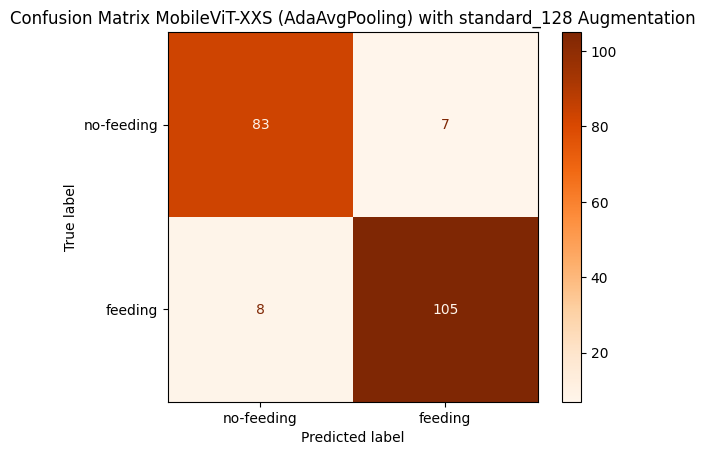

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.5084, Val loss:1.8656 Train acc: 0.7523, Val acc: 0.4655, Time: 10.76
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3184, Val loss:0.2828 Train acc: 0.8661, Val acc: 0.9022, Time: 10.77
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2477, Val loss:0.1973 Train acc: 0.8991, Val acc: 0.9245, Time: 10.87
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2667, Val loss:0.1580 Train acc: 0.8969, Val acc: 0.9330, Time: 10.82
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2407, Val loss:0.1968 Train acc: 0.9055, Val acc: 0.9160, Time: 10.54
Epoch 6/10 - Train loss: 0.2271, Val loss:0.1637 Train acc: 0.9086, Val acc: 0.9200, Time: 10.30
Epoch 7/10 - Train loss: 0.2101, Val loss:0.1452 Train acc: 0.9135, Val acc: 0.9468, Time: 10.44
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2406, Val loss:0.1598 Train acc: 0.9025, Val acc: 0.9330, Time: 10.24
Epoch 9/

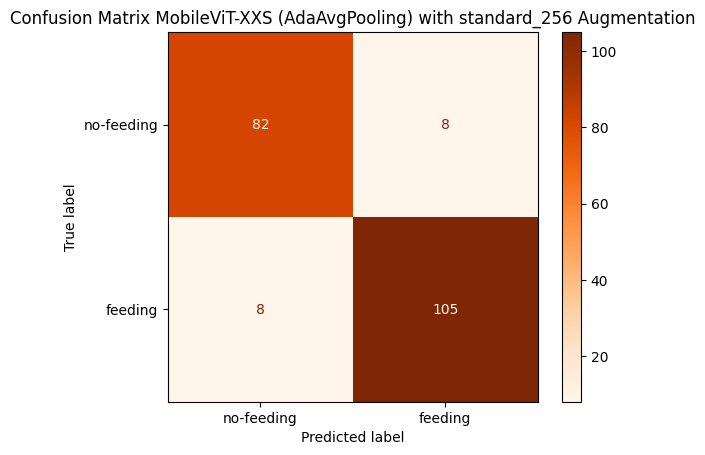

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.4325, Val loss:1.2552 Train acc: 0.7960, Val acc: 0.4485, Time: 11.86
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3040, Val loss:0.1773 Train acc: 0.8776, Val acc: 0.9375, Time: 11.87
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2616, Val loss:0.2261 Train acc: 0.8990, Val acc: 0.8977, Time: 11.86
Epoch 4/10 - Train loss: 0.2280, Val loss:0.1620 Train acc: 0.9159, Val acc: 0.9509, Time: 11.72
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2420, Val loss:0.1327 Train acc: 0.9055, Val acc: 0.9598, Time: 11.70
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2429, Val loss:0.1450 Train acc: 0.9012, Val acc: 0.9554, Time: 11.59
Epoch 7/10 - Train loss: 0.2277, Val loss:0.1646 Train acc: 0.9066, Val acc: 0.9554, Time: 11.71
Epoch 8/10 - Train loss: 0.2288, Val loss:0.1450 Train acc: 0.9108, Val acc: 0.9509, Time: 11.69
Epoch 9/10 - Train loss: 0.2218, Val

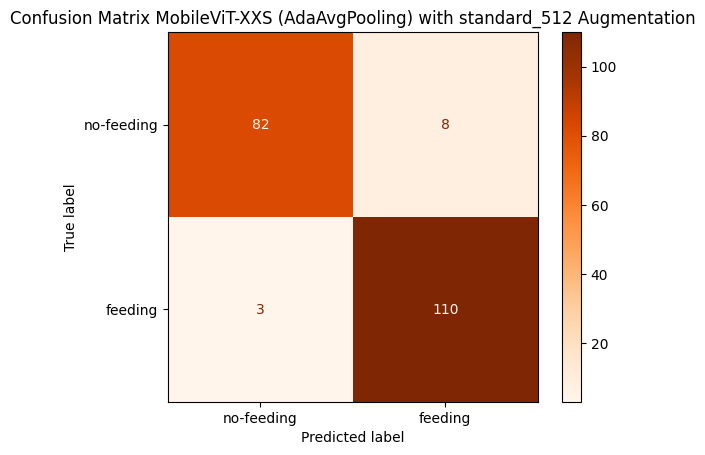

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.5989, Val loss:1.2209 Train acc: 0.6783, Val acc: 0.4314, Time: 9.95
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3671, Val loss:0.2189 Train acc: 0.8431, Val acc: 0.9334, Time: 9.86
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.3322, Val loss:0.2381 Train acc: 0.8597, Val acc: 0.9067, Time: 9.72
Epoch 4/10 - Train loss: 0.2851, Val loss:0.1955 Train acc: 0.8898, Val acc: 0.9375, Time: 9.62
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2814, Val loss:0.1895 Train acc: 0.8730, Val acc: 0.9200, Time: 9.79
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2991, Val loss:0.1612 Train acc: 0.8677, Val acc: 0.9420, Time: 9.79
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2682, Val loss:0.1863 Train acc: 0.8854, Val acc: 0.9334, Time: 9.69
Epoch 8/10 - Train loss: 0.2689, Val loss:0.1691 Train acc: 0.8952, Val acc: 0.9420, Time: 9.74
Epoch 9/10 - Train l

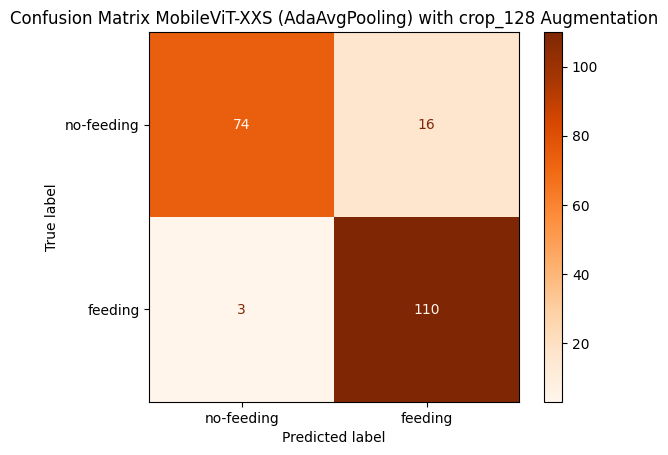

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.4960, Val loss:2.3024 Train acc: 0.7547, Val acc: 0.4314, Time: 9.91
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3413, Val loss:0.1949 Train acc: 0.8711, Val acc: 0.9554, Time: 9.88
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.3017, Val loss:0.1818 Train acc: 0.8773, Val acc: 0.9464, Time: 9.92
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2771, Val loss:0.1572 Train acc: 0.8927, Val acc: 0.9554, Time: 9.98
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2464, Val loss:0.1675 Train acc: 0.9022, Val acc: 0.9554, Time: 9.90
Epoch 6/10 - Train loss: 0.2507, Val loss:0.1730 Train acc: 0.9066, Val acc: 0.9334, Time: 9.98
Epoch 7/10 - Train loss: 0.2421, Val loss:0.2221 Train acc: 0.9083, Val acc: 0.9115, Time: 9.95
Epoch 8/10 - Train loss: 0.2377, Val loss:0.1507 Train acc: 0.9073, Val acc: 0.9558, Time: 9.90
save best model at epoch: 7
Epoch 9/10 - Train l

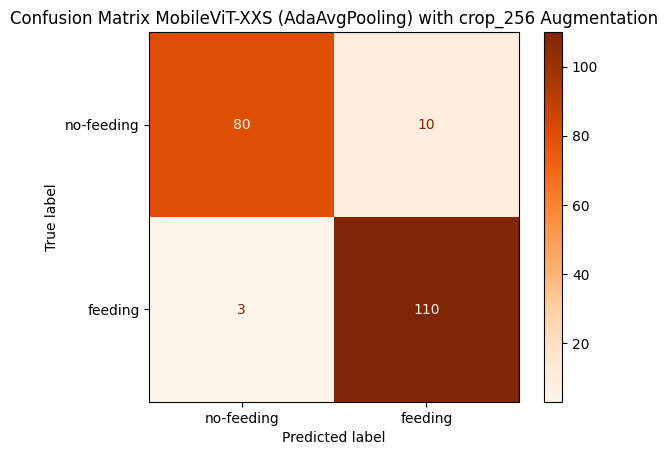

[RESULT] Model: MobileViT-XXS (AdaAvgPooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.4177, Val loss:2.4855 Train acc: 0.8199, Val acc: 0.4485, Time: 11.45
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2816, Val loss:0.2409 Train acc: 0.8846, Val acc: 0.9290, Time: 11.48
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2326, Val loss:0.2173 Train acc: 0.9119, Val acc: 0.9107, Time: 11.40
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2188, Val loss:0.1358 Train acc: 0.9065, Val acc: 0.9647, Time: 11.32
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2196, Val loss:0.1834 Train acc: 0.9110, Val acc: 0.9428, Time: 11.26
Epoch 6/10 - Train loss: 0.2107, Val loss:0.1391 Train acc: 0.9135, Val acc: 0.9732, Time: 11.35
Epoch 7/10 - Train loss: 0.1991, Val loss:0.1784 Train acc: 0.9156, Val acc: 0.9598, Time: 11.34
Epoch 8/10 - Train loss: 0.1980, Val loss:0.2537 Train acc: 0.9210, Val acc: 0.8620, Time: 11.30
Epoch 9/10 - Train loss: 0.1984, Val los

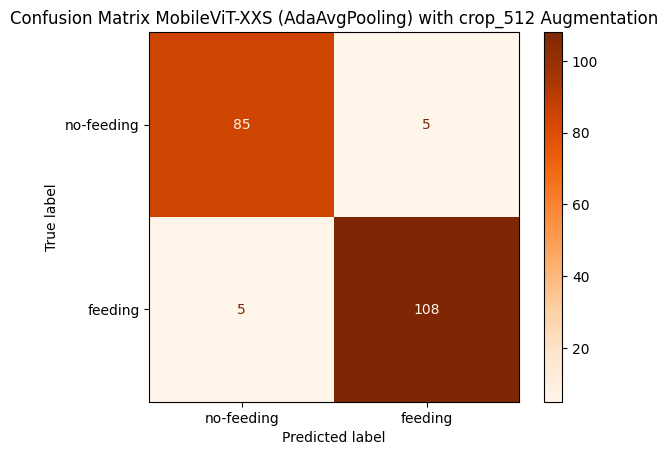

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.5495, Val loss:0.4438 Train acc: 0.7263, Val acc: 0.7687, Time: 9.65
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3278, Val loss:0.1389 Train acc: 0.8574, Val acc: 0.9688, Time: 9.49
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.3417, Val loss:0.1990 Train acc: 0.8599, Val acc: 0.9111, Time: 9.59
Epoch 4/10 - Train loss: 0.3107, Val loss:0.1525 Train acc: 0.8710, Val acc: 0.9598, Time: 9.47
Epoch 5/10 - Train loss: 0.2884, Val loss:0.1552 Train acc: 0.8866, Val acc: 0.9554, Time: 9.45
Epoch 6/10 - Train loss: 0.2765, Val loss:0.1418 Train acc: 0.8858, Val acc: 0.9554, Time: 9.57
Epoch 7/10 - Train loss: 0.2736, Val loss:0.1604 Train acc: 0.8876, Val acc: 0.9420, Time: 9.48
Epoch 8/10 - Train loss: 0.2483, Val loss:0.1138 Train acc: 0.8942, Val acc: 0.9464, Time: 9.50
save best model at epoch: 7
Epoch 9/10 - Train loss: 0.2284, Val loss:0.1985 Train acc: 0.9065, Val a

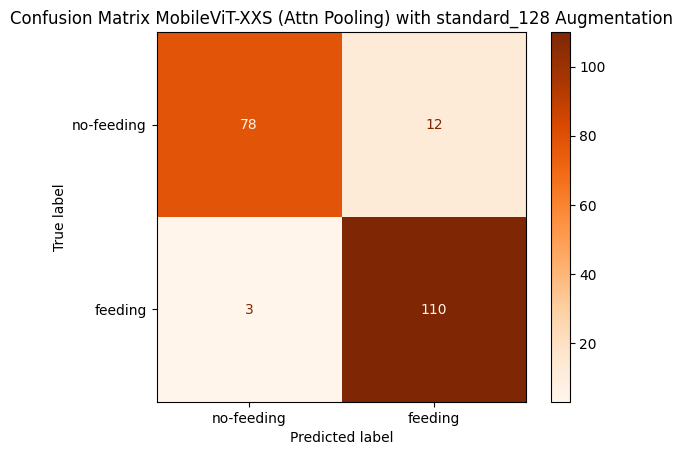

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.4362, Val loss:2.0046 Train acc: 0.8074, Val acc: 0.4314, Time: 10.05
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2779, Val loss:0.1931 Train acc: 0.8865, Val acc: 0.9420, Time: 9.85
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2845, Val loss:0.1560 Train acc: 0.8938, Val acc: 0.9464, Time: 9.95
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2586, Val loss:0.2016 Train acc: 0.9002, Val acc: 0.9196, Time: 9.88
Epoch 5/10 - Train loss: 0.2557, Val loss:0.1670 Train acc: 0.9043, Val acc: 0.9379, Time: 9.94
Epoch 6/10 - Train loss: 0.2629, Val loss:0.1446 Train acc: 0.8952, Val acc: 0.9509, Time: 10.02
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2393, Val loss:0.1496 Train acc: 0.9031, Val acc: 0.9509, Time: 9.95
Epoch 8/10 - Train loss: 0.2479, Val loss:0.1504 Train acc: 0.9001, Val acc: 0.9420, Time: 9.94
Epoch 9/10 - Train loss: 0.2290, Val loss:0

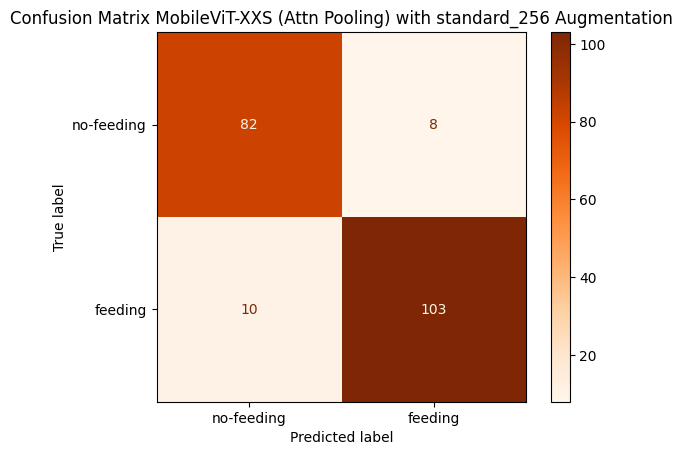

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.4579, Val loss:1.5002 Train acc: 0.7647, Val acc: 0.5905, Time: 11.40
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2800, Val loss:0.1967 Train acc: 0.8887, Val acc: 0.9330, Time: 11.43
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2828, Val loss:0.1301 Train acc: 0.8867, Val acc: 0.9643, Time: 11.39
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2739, Val loss:0.1420 Train acc: 0.8907, Val acc: 0.9643, Time: 11.45
Epoch 5/10 - Train loss: 0.2357, Val loss:0.1039 Train acc: 0.9052, Val acc: 0.9688, Time: 11.40
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2710, Val loss:0.1477 Train acc: 0.9004, Val acc: 0.9598, Time: 11.61
Epoch 7/10 - Train loss: 0.2282, Val loss:0.1551 Train acc: 0.9095, Val acc: 0.9383, Time: 11.38
Epoch 8/10 - Train loss: 0.2768, Val loss:0.1474 Train acc: 0.8762, Val acc: 0.9643, Time: 11.38
Epoch 9/10 - Train loss: 0.2159, Val 

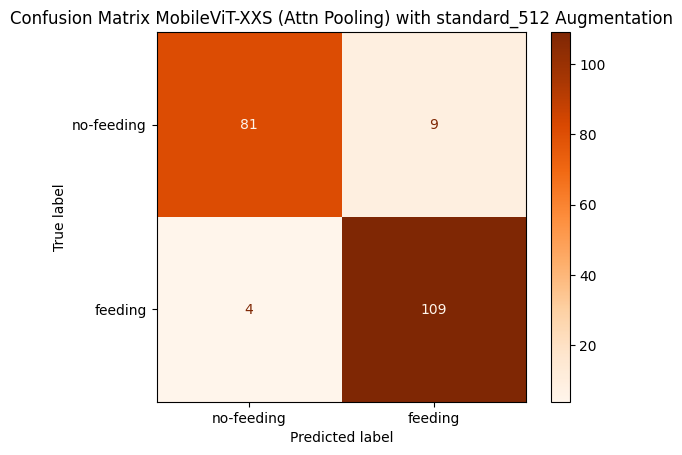

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.5540, Val loss:1.8128 Train acc: 0.6985, Val acc: 0.4144, Time: 9.65
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3206, Val loss:0.2924 Train acc: 0.8754, Val acc: 0.8933, Time: 9.66
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.3169, Val loss:0.1991 Train acc: 0.8735, Val acc: 0.9200, Time: 9.62
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2907, Val loss:0.1727 Train acc: 0.8827, Val acc: 0.9464, Time: 9.54
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2831, Val loss:0.2075 Train acc: 0.8772, Val acc: 0.9026, Time: 9.60
Epoch 6/10 - Train loss: 0.2842, Val loss:0.1615 Train acc: 0.8890, Val acc: 0.9286, Time: 9.54
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2764, Val loss:0.2009 Train acc: 0.8851, Val acc: 0.9200, Time: 9.62
Epoch 8/10 - Train loss: 0.2569, Val loss:0.1681 Train acc: 0.8919, Val acc: 0.9115, Time: 9.68
Epoch 9/10 - Train lo

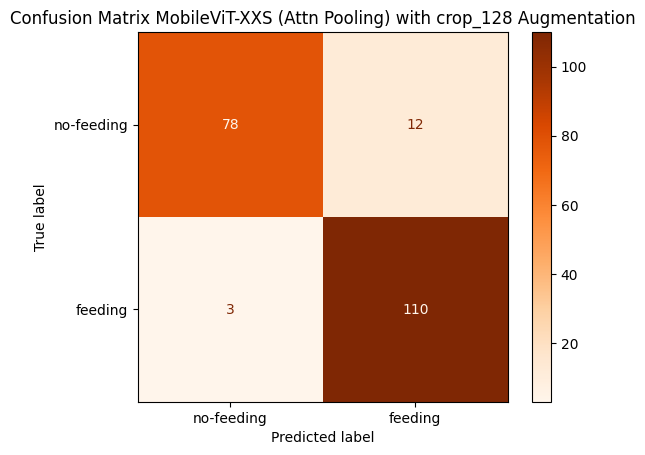

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.4390, Val loss:1.4083 Train acc: 0.8087, Val acc: 0.4399, Time: 10.00
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3028, Val loss:0.1422 Train acc: 0.8837, Val acc: 0.9643, Time: 10.01
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2628, Val loss:0.1598 Train acc: 0.8990, Val acc: 0.9688, Time: 10.09
Epoch 4/10 - Train loss: 0.2711, Val loss:0.1313 Train acc: 0.8994, Val acc: 0.9643, Time: 10.27
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2630, Val loss:0.1282 Train acc: 0.9021, Val acc: 0.9509, Time: 10.03
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2537, Val loss:0.1385 Train acc: 0.8982, Val acc: 0.9598, Time: 10.10
Epoch 7/10 - Train loss: 0.2455, Val loss:0.1384 Train acc: 0.8950, Val acc: 0.9330, Time: 10.03
Epoch 8/10 - Train loss: 0.2385, Val loss:0.1425 Train acc: 0.9025, Val acc: 0.9509, Time: 10.05
Epoch 9/10 - Train loss: 0.2362, Val loss

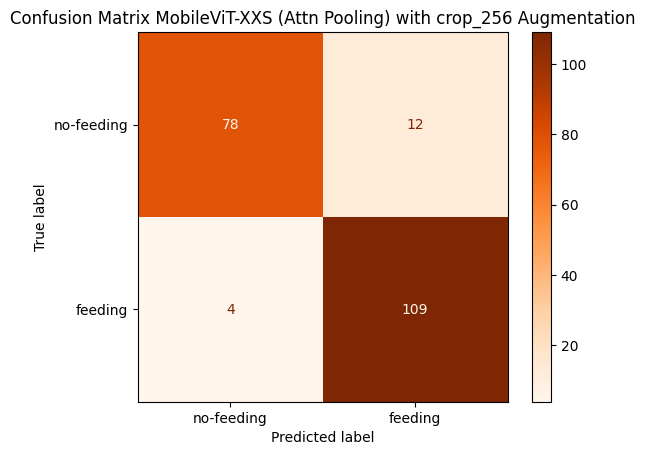

[RESULT] Model: MobileViT-XXS (Attn Pooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.4463, Val loss:2.4147 Train acc: 0.7930, Val acc: 0.4399, Time: 11.47
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3084, Val loss:0.2889 Train acc: 0.8732, Val acc: 0.8620, Time: 11.48
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2734, Val loss:0.3009 Train acc: 0.8816, Val acc: 0.8575, Time: 11.41
Epoch 4/10 - Train loss: 0.2470, Val loss:0.3109 Train acc: 0.8969, Val acc: 0.8446, Time: 11.43
Epoch 5/10 - Train loss: 0.2369, Val loss:0.1493 Train acc: 0.9074, Val acc: 0.9509, Time: 11.43
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2373, Val loss:0.3609 Train acc: 0.8948, Val acc: 0.8405, Time: 11.45
Epoch 7/10 - Train loss: 0.2124, Val loss:0.1769 Train acc: 0.9189, Val acc: 0.9379, Time: 11.39
Epoch 8/10 - Train loss: 0.2152, Val loss:0.3892 Train acc: 0.9148, Val acc: 0.8007, Time: 11.33
Epoch 9/10 - Train loss: 0.2032, Val loss:0.2112 Train acc: 0.9117, V

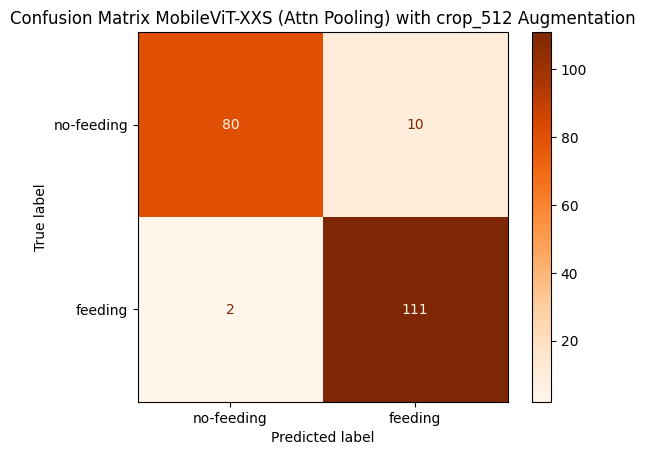

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.4390, Val loss:0.9307 Train acc: 0.7816, Val acc: 0.4485, Time: 9.46
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3034, Val loss:0.3362 Train acc: 0.8803, Val acc: 0.8490, Time: 9.45
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2717, Val loss:0.1677 Train acc: 0.8854, Val acc: 0.9509, Time: 9.58
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2458, Val loss:0.1533 Train acc: 0.9021, Val acc: 0.9554, Time: 9.58
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2615, Val loss:0.2445 Train acc: 0.9034, Val acc: 0.9067, Time: 9.55
Epoch 6/10 - Train loss: 0.2630, Val loss:0.1315 Train acc: 0.9022, Val acc: 0.9509, Time: 9.55
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2663, Val loss:0.1641 Train acc: 0.8942, Val acc: 0.9464, Time: 9.61
Epoch 8/10 - Train loss: 0.2460, Val loss:0.1606 Train acc: 0.8942, Val acc: 0.9464, Time: 9.54
Epoch 9/10 - Tra

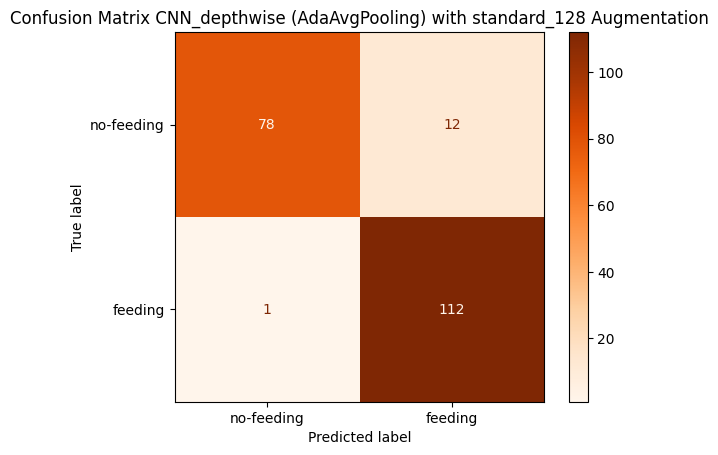

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.3885, Val loss:1.7721 Train acc: 0.8398, Val acc: 0.4399, Time: 9.93
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2796, Val loss:0.1841 Train acc: 0.9021, Val acc: 0.9732, Time: 9.96
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2776, Val loss:0.1688 Train acc: 0.8845, Val acc: 0.9509, Time: 9.89
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2570, Val loss:0.1745 Train acc: 0.9010, Val acc: 0.9554, Time: 9.99
Epoch 5/10 - Train loss: 0.2450, Val loss:0.4931 Train acc: 0.8969, Val acc: 0.7346, Time: 9.96
Epoch 6/10 - Train loss: 0.2452, Val loss:0.1425 Train acc: 0.9066, Val acc: 0.9509, Time: 9.95
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2231, Val loss:0.3226 Train acc: 0.9142, Val acc: 0.8397, Time: 9.97
Epoch 8/10 - Train loss: 0.2428, Val loss:0.2104 Train acc: 0.9086, Val acc: 0.9160, Time: 9.97
Epoch 9/10 - Train loss: 0.2509, Val loss:0.

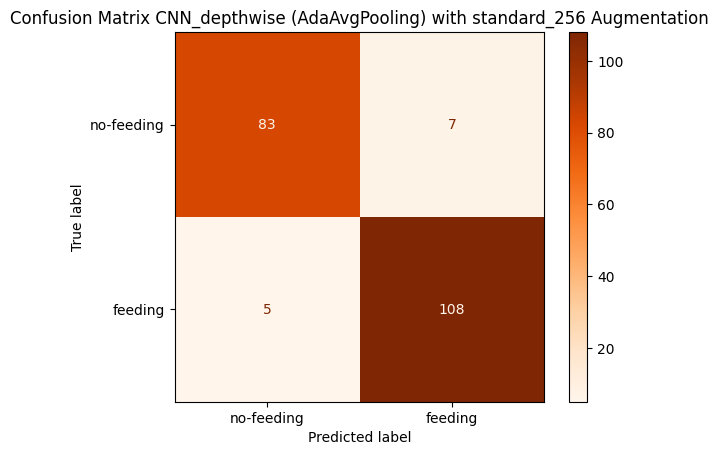

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.4145, Val loss:2.3941 Train acc: 0.8210, Val acc: 0.4314, Time: 11.54
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2670, Val loss:0.1570 Train acc: 0.8982, Val acc: 0.9334, Time: 11.54
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2558, Val loss:0.1403 Train acc: 0.9096, Val acc: 0.9464, Time: 11.70
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2389, Val loss:0.1341 Train acc: 0.9169, Val acc: 0.9643, Time: 11.75
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2384, Val loss:0.1642 Train acc: 0.9058, Val acc: 0.9602, Time: 11.66
Epoch 6/10 - Train loss: 0.2602, Val loss:0.1311 Train acc: 0.9002, Val acc: 0.9647, Time: 11.60
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2366, Val loss:0.2672 Train acc: 0.9045, Val acc: 0.8803, Time: 11.65
Epoch 8/10 - Train loss: 0.2129, Val loss:0.1104 Train acc: 0.9167, Val acc: 0.9732, Time: 11.68
save bes

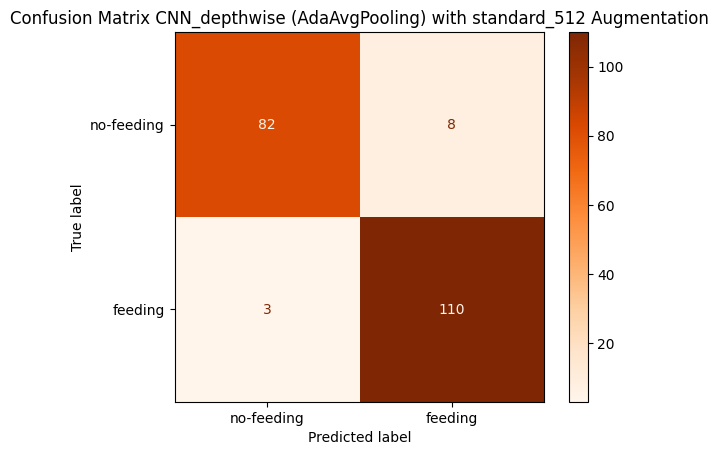

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.4189, Val loss:1.7184 Train acc: 0.8316, Val acc: 0.4229, Time: 9.60
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2844, Val loss:0.1812 Train acc: 0.8869, Val acc: 0.9554, Time: 9.50
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2578, Val loss:0.1278 Train acc: 0.8958, Val acc: 0.9598, Time: 9.52
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2369, Val loss:0.1219 Train acc: 0.9208, Val acc: 0.9643, Time: 9.56
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2649, Val loss:0.1682 Train acc: 0.8950, Val acc: 0.9338, Time: 9.45
Epoch 6/10 - Train loss: 0.2327, Val loss:0.1152 Train acc: 0.9023, Val acc: 0.9509, Time: 9.48
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2651, Val loss:0.2851 Train acc: 0.8980, Val acc: 0.8531, Time: 9.46
Epoch 8/10 - Train loss: 0.2323, Val loss:0.4067 Train acc: 0.8950, Val acc: 0.8231, Time: 9.46
Epoch 9/10 - Train l

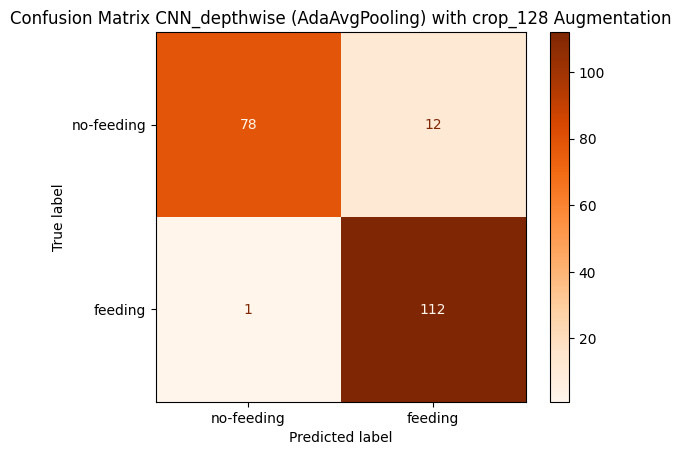

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.4132, Val loss:3.2880 Train acc: 0.8067, Val acc: 0.4229, Time: 10.07
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2794, Val loss:0.1969 Train acc: 0.8918, Val acc: 0.9509, Time: 10.18
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2430, Val loss:0.2306 Train acc: 0.9021, Val acc: 0.9107, Time: 10.01
Epoch 4/10 - Train loss: 0.2729, Val loss:0.2655 Train acc: 0.8933, Val acc: 0.8843, Time: 10.00
Epoch 5/10 - Train loss: 0.2435, Val loss:0.1644 Train acc: 0.9112, Val acc: 0.9554, Time: 10.05
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2362, Val loss:0.1890 Train acc: 0.9055, Val acc: 0.9111, Time: 10.04
Epoch 7/10 - Train loss: 0.2202, Val loss:0.1392 Train acc: 0.9210, Val acc: 0.9598, Time: 10.13
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2483, Val loss:0.1363 Train acc: 0.9002, Val acc: 0.9509, Time: 10.01
save best model at epoch: 7
Epoch 9/10 -

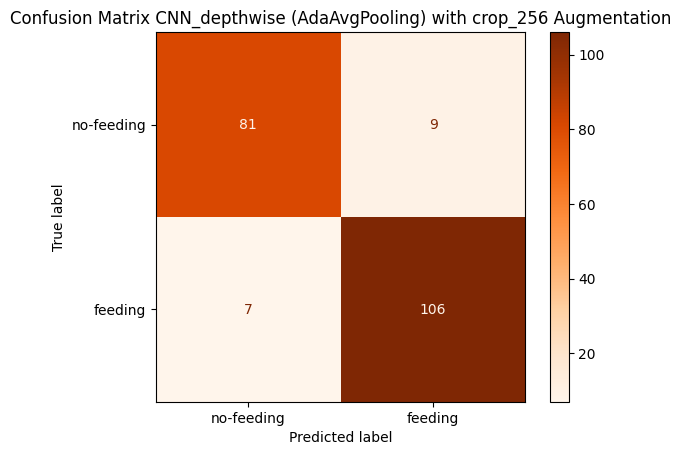

[RESULT] Model: CNN_depthwise (AdaAvgPooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3726, Val loss:3.5840 Train acc: 0.8325, Val acc: 0.4485, Time: 11.49
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2711, Val loss:0.1737 Train acc: 0.9042, Val acc: 0.9424, Time: 11.41
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2615, Val loss:0.2111 Train acc: 0.8979, Val acc: 0.9420, Time: 11.55
Epoch 4/10 - Train loss: 0.2514, Val loss:0.1568 Train acc: 0.9095, Val acc: 0.9688, Time: 11.47
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2213, Val loss:0.2704 Train acc: 0.9117, Val acc: 0.8401, Time: 11.50
Epoch 6/10 - Train loss: 0.2353, Val loss:0.1830 Train acc: 0.9079, Val acc: 0.9598, Time: 11.48
Epoch 7/10 - Train loss: 0.2034, Val loss:0.1318 Train acc: 0.9138, Val acc: 0.9554, Time: 11.50
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2429, Val loss:0.1660 Train acc: 0.9032, Val acc: 0.9379, Time: 11.49
Epoch 9/10 - Train loss: 0.1944, Val los

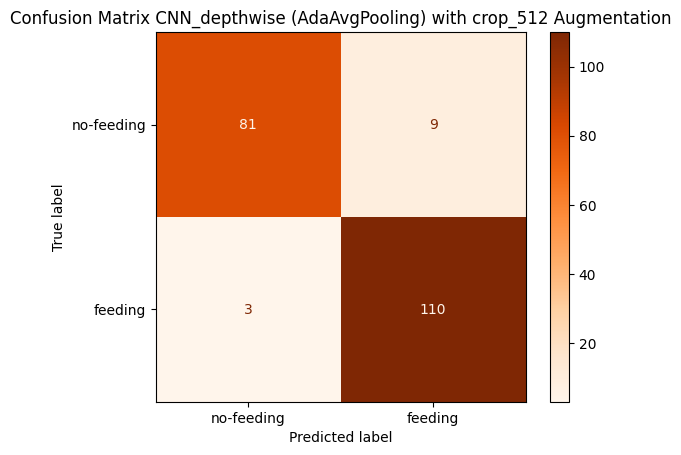

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: standard_128 
Epoch 1/10 - Train loss: 0.4059, Val loss:0.5396 Train acc: 0.8148, Val acc: 0.6976, Time: 9.74
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2711, Val loss:0.1944 Train acc: 0.8942, Val acc: 0.9420, Time: 9.61
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2757, Val loss:0.2037 Train acc: 0.8928, Val acc: 0.9062, Time: 9.58
Epoch 4/10 - Train loss: 0.2720, Val loss:0.1539 Train acc: 0.8797, Val acc: 0.9598, Time: 9.61
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2404, Val loss:0.1359 Train acc: 0.9066, Val acc: 0.9643, Time: 9.64
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2401, Val loss:0.1472 Train acc: 0.9075, Val acc: 0.9468, Time: 9.60
Epoch 7/10 - Train loss: 0.2141, Val loss:0.1375 Train acc: 0.9105, Val acc: 0.9643, Time: 9.53
Epoch 8/10 - Train loss: 0.2125, Val loss:0.1249 Train acc: 0.9096, Val acc: 0.9558, Time: 9.58
save best model at epoch: 7
Epoch 9/10 - Trai

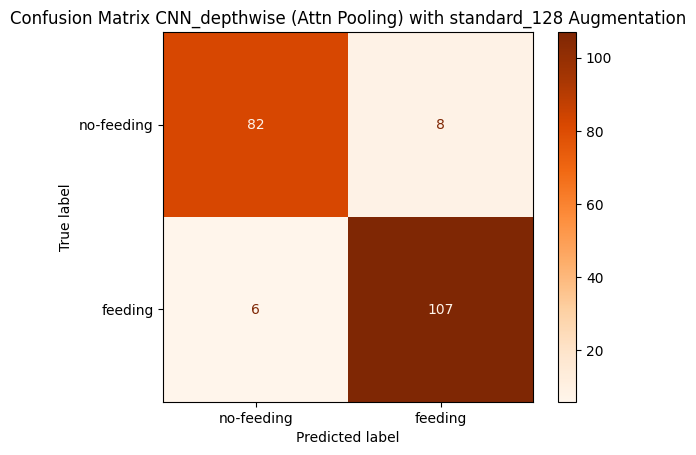

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: standard_256 
Epoch 1/10 - Train loss: 0.3689, Val loss:1.7527 Train acc: 0.8471, Val acc: 0.4485, Time: 9.96
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2892, Val loss:0.2435 Train acc: 0.8825, Val acc: 0.8981, Time: 9.97
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2350, Val loss:0.1703 Train acc: 0.9105, Val acc: 0.9602, Time: 9.97
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2524, Val loss:0.1729 Train acc: 0.9034, Val acc: 0.9509, Time: 9.97
Epoch 5/10 - Train loss: 0.2307, Val loss:0.1216 Train acc: 0.9104, Val acc: 0.9598, Time: 9.94
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2385, Val loss:0.1746 Train acc: 0.8910, Val acc: 0.9241, Time: 9.93
Epoch 7/10 - Train loss: 0.2231, Val loss:0.1698 Train acc: 0.9053, Val acc: 0.9334, Time: 9.93
Epoch 8/10 - Train loss: 0.2092, Val loss:0.2110 Train acc: 0.9140, Val acc: 0.9026, Time: 9.89
Epoch 9/10 - Train loss: 0.1936, Val loss:0.1

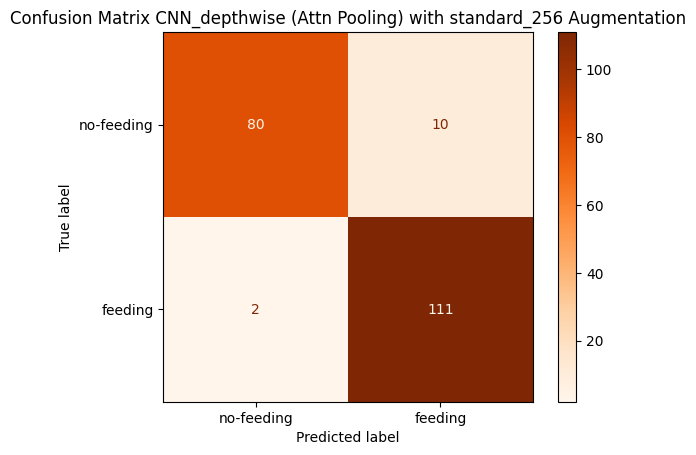

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: standard_512 
Epoch 1/10 - Train loss: 0.3779, Val loss:3.6826 Train acc: 0.8431, Val acc: 0.4314, Time: 11.63
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2587, Val loss:0.3869 Train acc: 0.8962, Val acc: 0.8084, Time: 11.62
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2520, Val loss:0.1632 Train acc: 0.9006, Val acc: 0.9602, Time: 11.58
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2242, Val loss:0.1423 Train acc: 0.9139, Val acc: 0.9464, Time: 11.65
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2249, Val loss:0.1489 Train acc: 0.9118, Val acc: 0.9598, Time: 11.70
Epoch 6/10 - Train loss: 0.2085, Val loss:0.1286 Train acc: 0.9230, Val acc: 0.9464, Time: 11.73
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2100, Val loss:0.1900 Train acc: 0.9157, Val acc: 0.9245, Time: 11.63
Epoch 8/10 - Train loss: 0.1983, Val loss:0.1310 Train acc: 0.9210, Val acc: 0.9688, Time: 11.63
Epoch 9/1

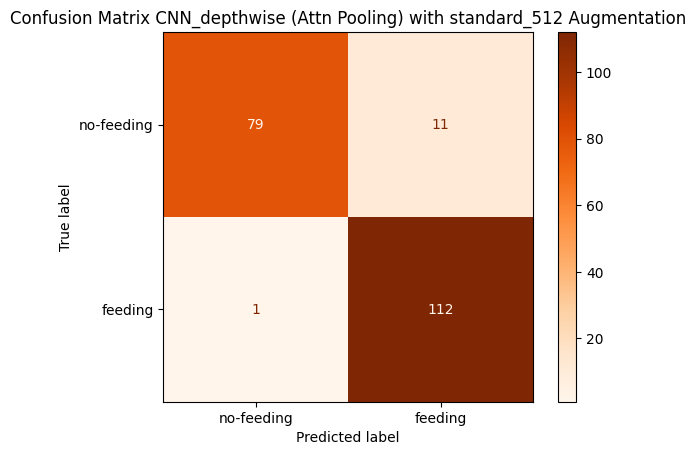

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: crop_128 
Epoch 1/10 - Train loss: 0.4067, Val loss:0.9392 Train acc: 0.8263, Val acc: 0.4485, Time: 9.55
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.3099, Val loss:0.1908 Train acc: 0.8721, Val acc: 0.9598, Time: 9.48
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2774, Val loss:0.2027 Train acc: 0.8961, Val acc: 0.9330, Time: 9.57
Epoch 4/10 - Train loss: 0.2474, Val loss:0.1807 Train acc: 0.8990, Val acc: 0.9379, Time: 9.56
save best model at epoch: 3
Epoch 5/10 - Train loss: 0.2720, Val loss:0.1618 Train acc: 0.8912, Val acc: 0.9643, Time: 9.55
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2361, Val loss:0.1663 Train acc: 0.9023, Val acc: 0.9420, Time: 9.54
Epoch 7/10 - Train loss: 0.2281, Val loss:0.1465 Train acc: 0.9065, Val acc: 0.9509, Time: 9.50
save best model at epoch: 6
Epoch 8/10 - Train loss: 0.2193, Val loss:0.1735 Train acc: 0.9147, Val acc: 0.9554, Time: 9.57
Epoch 9/10 - Train lo

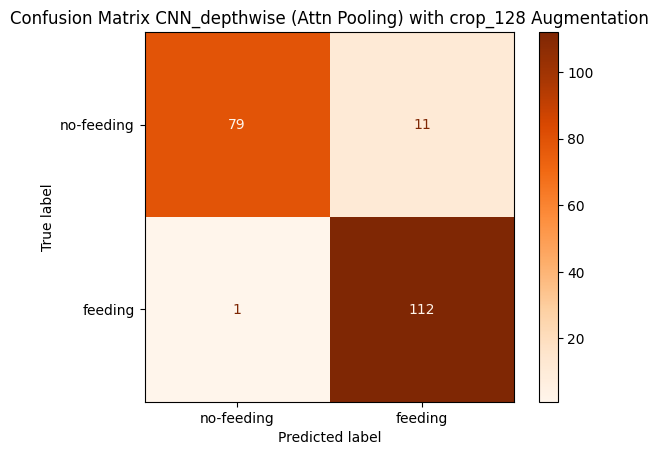

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: crop_256 
Epoch 1/10 - Train loss: 0.3925, Val loss:1.1820 Train acc: 0.8297, Val acc: 0.4399, Time: 10.00
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2437, Val loss:0.1448 Train acc: 0.8992, Val acc: 0.9688, Time: 9.90
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2320, Val loss:0.1633 Train acc: 0.9036, Val acc: 0.9420, Time: 9.94
Epoch 4/10 - Train loss: 0.2120, Val loss:0.2334 Train acc: 0.9250, Val acc: 0.9018, Time: 10.05
Epoch 5/10 - Train loss: 0.2319, Val loss:0.1414 Train acc: 0.9178, Val acc: 0.9732, Time: 9.96
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2303, Val loss:0.1687 Train acc: 0.9115, Val acc: 0.9513, Time: 9.95
Epoch 7/10 - Train loss: 0.2067, Val loss:0.1767 Train acc: 0.9177, Val acc: 0.9472, Time: 9.96
Epoch 8/10 - Train loss: 0.2002, Val loss:0.1218 Train acc: 0.9260, Val acc: 0.9379, Time: 9.95
save best model at epoch: 7
Epoch 9/10 - Train loss: 0.1957, Val loss:0.140

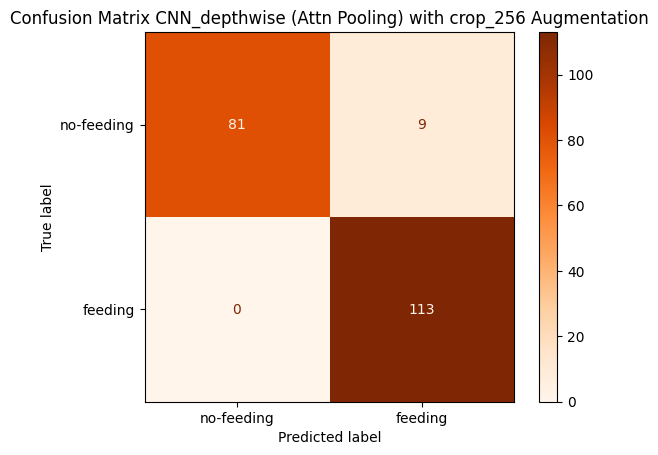

[RESULT] Model: CNN_depthwise (Attn Pooling) | Augmentation: crop_512 
Epoch 1/10 - Train loss: 0.3961, Val loss:3.7543 Train acc: 0.8251, Val acc: 0.4229, Time: 11.57
save best model at epoch: 0
Epoch 2/10 - Train loss: 0.2487, Val loss:0.2851 Train acc: 0.8992, Val acc: 0.8709, Time: 11.61
save best model at epoch: 1
Epoch 3/10 - Train loss: 0.2295, Val loss:0.2042 Train acc: 0.9115, Val acc: 0.9464, Time: 11.64
save best model at epoch: 2
Epoch 4/10 - Train loss: 0.2270, Val loss:0.2124 Train acc: 0.9085, Val acc: 0.9067, Time: 11.61
Epoch 5/10 - Train loss: 0.2191, Val loss:0.1989 Train acc: 0.9159, Val acc: 0.9375, Time: 11.67
save best model at epoch: 4
Epoch 6/10 - Train loss: 0.2134, Val loss:0.1474 Train acc: 0.9190, Val acc: 0.9647, Time: 11.71
save best model at epoch: 5
Epoch 7/10 - Train loss: 0.2497, Val loss:0.1767 Train acc: 0.9056, Val acc: 0.9643, Time: 11.66
Epoch 8/10 - Train loss: 0.2044, Val loss:0.2817 Train acc: 0.9232, Val acc: 0.8535, Time: 11.74
Epoch 9/10 - 

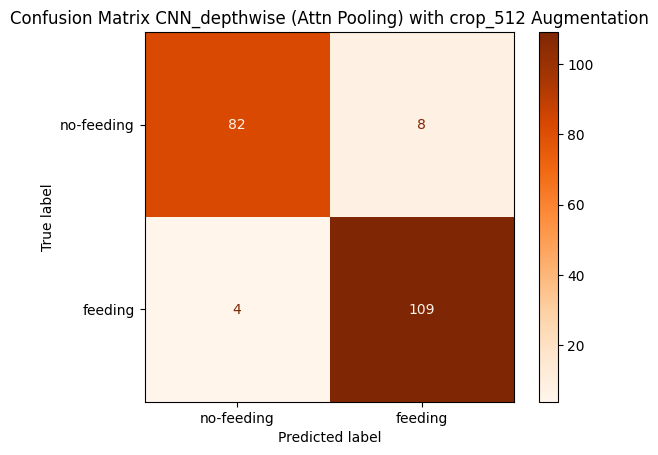

            Model        Pooling  Augmentation  Accuracy  Precision  Recall  \
0     MobileViT-S  AdaAvgPooling  standard_128    0.9310     0.9160  0.9646   
1     MobileViT-S  AdaAvgPooling  standard_256    0.9507     0.9256  0.9912   
2     MobileViT-S  AdaAvgPooling  standard_512    0.9507     0.9402  0.9735   
3     MobileViT-S  AdaAvgPooling      crop_128    0.9163     0.9364  0.9115   
4     MobileViT-S  AdaAvgPooling      crop_256    0.9212     0.9145  0.9469   
5     MobileViT-S  AdaAvgPooling      crop_512    0.9310     0.9160  0.9646   
6     MobileViT-S   Attn Pooling  standard_128    0.9310     0.9304  0.9469   
7     MobileViT-S   Attn Pooling  standard_256    0.9212     0.9369  0.9204   
8     MobileViT-S   Attn Pooling  standard_512    0.9458     0.9322  0.9735   
9     MobileViT-S   Attn Pooling      crop_128    0.9360     0.9098  0.9823   
10    MobileViT-S   Attn Pooling      crop_256    0.9310     0.9381  0.9381   
11    MobileViT-S   Attn Pooling      crop_512    0.

In [ ]:
# @title Top 1 score on various configuration

models = {
    'MobileViT-S': s,
    'MobileViT-XS': xs,
    'MobileViT-XXS': xxs,
    'CNN_depthwise' : MiniCNN
}
augmentations = {
    'standard_128': {
        'train': transform_128,
        'eval': eval_transform_128
    },
    'standard_256': {
        'train': transform_256,
        'eval': eval_transform_256
    },
    'standard_512': {
        'train': transform_512,
        'eval': eval_transform_512
    },
    'crop_128': {
        'train': transform_crop_128,
        'eval': eval_transform_128
    },
    'crop_256': {
        'train': transform_crop_256,
        'eval': eval_transform_256
    },
    'crop_512': {
        'train': transform_crop_512,
        'eval': eval_transform_512
    }

}

results=[]



for model_name, model_fn in models.items():
  for attn_pooling in [False, True]:
    for aug_name, aug in augmentations.items():

      #Init
      model = model_fn(attn=attn_pooling).to(device)


      criterion = nn.CrossEntropyLoss()
      metric_function=accuracy
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)

      #prepare data
      train_transform = aug['train']
      eval_transform = aug['eval']

      train_set = ImageDataset(train_paths, train_labels,transform=train_transform)
      val_set = ImageDataset(val_paths, val_labels,transform=eval_transform)
      test_set = ImageDataset(test_paths, test_labels,transform=eval_transform )

      train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
      vali_loader = DataLoader(val_set, batch_size = batch_size, shuffle= True)
      test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

      #train
      attn_status = "Attn Pooling" if attn_pooling else "AdaAvgPooling"
      print(f"[RESULT] Model: {model_name} ({attn_status}) | Augmentation: {aug_name} ")
      train_model(num_epochs,train_loader,vali_loader,model,optimizer, criterion, metric_function, patience, device, "best_model.pt")

      #load and evaluate the best model
      model.load_state_dict(torch.load("best_model.pt"))
      model.eval()

      cpu = torch.device('cpu')
      model.to(cpu)
      acc, prec, rec, f1, cm, avg_infer_time = test(model, test_loader, device= cpu)



      #visulization CONFUZION MATRIX
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no-feeding', 'feeding'])
      disp.plot(cmap=plt.cm.Oranges )
      plt.title(f'Confusion Matrix {model_name} ({attn_status}) with {aug_name} Augmentation')
      plt.show()


      #save
      results.append({
            'Model': model_name,
            'Pooling' : attn_status,
            'Augmentation': aug_name,
            'Accuracy': round(acc, 4),
            'Precision': round(prec, 4),
            'Recall' : round(rec, 4),
            'F1_score' : round(f1, 4),
            'avg_infer_time[ms]' : round(avg_infer_time *1000, 2)
        })

df_results = pd.DataFrame(results)
print(df_results)

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


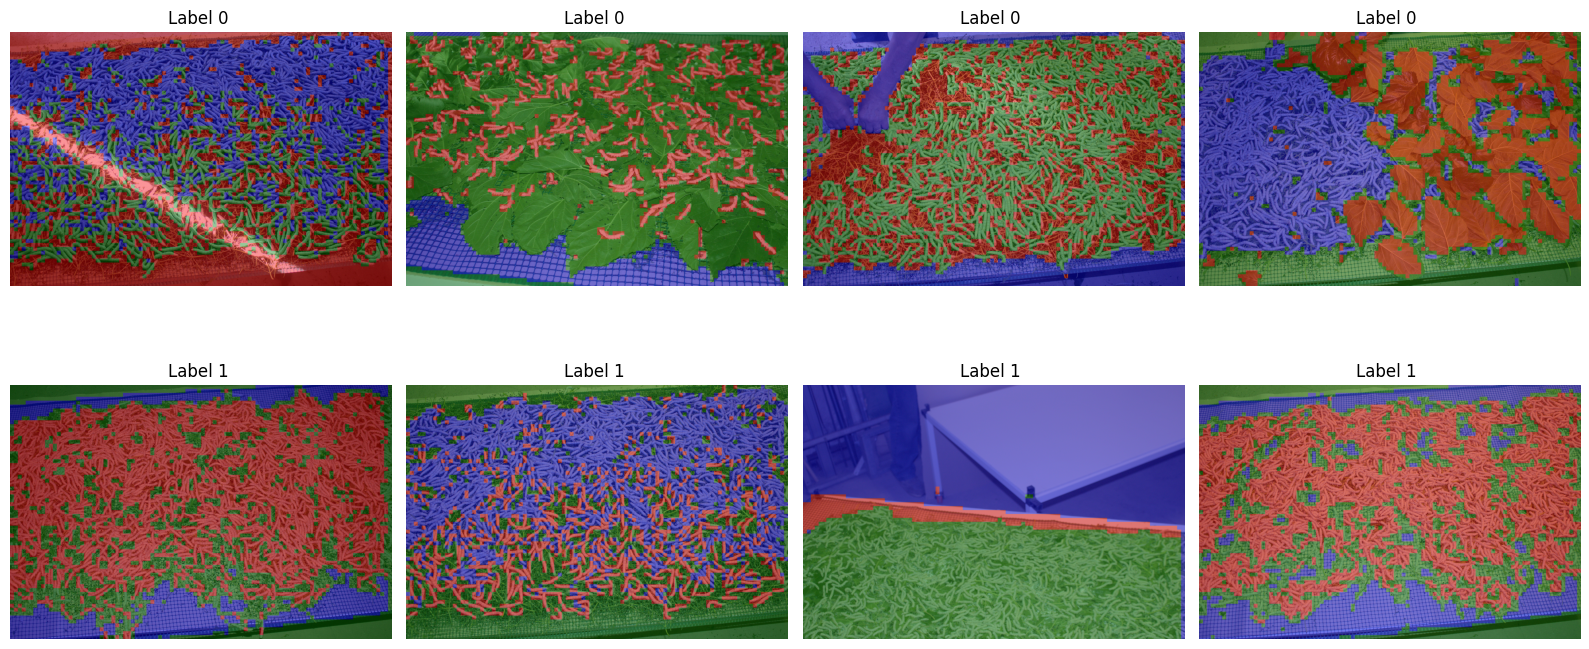

In [ ]:
# @title Unsupervised Semantic Segmentation
model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
model.eval()

#layer to extract the feature 2 or 3
layer = model.layer3

#append on feature the result of dino as feature extractor
features = []
def hook_fn(module, input, output):
    features.append(output)

#register the output of model when i call th layer
handle = layer.register_forward_hook(hook_fn)

segmented_images = {'0': [], '1': []}

# Loop on classes saved in folder called 0 and 1
for label in ['0', '1']:
    class_dir = os.path.join("/content/bachi_rappresentativi", label)
    image_paths = glob(os.path.join(class_dir, '*.jpg'))

    for img_path in image_paths:
        features.clear()


        image = Image.open(img_path).convert("RGB")
        #add dimension bach
        input_tensor = pre_trained_transform(image).unsqueeze(0) # Shape: [B,C,H,W]

        with torch.no_grad():
            _ = model(input_tensor)

        # Extract
        feat_map = features[0].squeeze(0) # Shape: [C,H, W]
        C, H, W = feat_map.shape
        #reshape for k-means
        feat_flat = feat_map.permute(1, 2, 0).reshape(-1, C)  # [H*W, C]


        # segmntation
        kmeans = KMeans(n_clusters=3, random_state=0)
        labels = kmeans.fit_predict(feat_flat.numpy())
        segmentation = labels.reshape(H, W)

        # Upsample of seg_map to overlap on the image
        segmentation_img = Image.fromarray(segmentation.astype(np.uint8), mode='L')
        segmentation_img = segmentation_img.resize(image.size, resample=Image.NEAREST)

        # Color mapping
        seg_np = np.array(segmentation_img)
        cmap = ListedColormap(['red', 'green', 'blue'])
        seg_color = cmap(seg_np / seg_np.max())
        seg_overlay = Image.fromarray((seg_color[:, :, :3] * 255).astype(np.uint8))
        segmented_images[label].append((np.array(image), np.array(seg_overlay)))
        sil_score = silhouette_score(feat_flat.numpy(), labels)


# plot some example
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, label in enumerate(['0', '1']):
    for j in range(4):
        orig, overlay = segmented_images[label][j]
        axs[i, j].imshow(orig)
        axs[i, j].imshow(overlay, alpha=0.4)
        axs[i, j].set_title(f"Label {label} ")
        axs[i, j].axis("off")

plt.tight_layout()
plt.show()